__Name: Brandon Tchaka NIYUNGEKO__

# Predictive Modelling of Credit Risk in Peer-to-Peer Lending

## Introduction

This notebook presents an approach to predicting credit risk in peer-to-peer lending platforms using machine learning techniques. Our goal is to develop robust models that can accurately assess borrower solvency by leveraging both individual borrower characteristics and macroeconomic indicators.

## Methodology Overview

1. **Data Preprocessing**: Done in `my_cleaning_preprocessing.ipynb`.

2. **Model Development**: We implement and compare three main types of models:
   - Logistic Regression
   - Random Forest
   - XGBoost

3. **Addressing Class Imbalance**: Given the imbalanced nature of credit default data, we employ techniques such as class weighting and SMOTE (Synthetic Minority Over-sampling Technique).

4. **Hyperparameter Tuning**: We use advanced techniques like RandomizedSearchCV and Bayesian Optimization to fine-tune our models.

5. **Model Calibration**: To ensure reliable probability estimates, we apply various calibration methods including Platt Scaling, Isotonic Regression, and Beta Calibration.

6. **Threshold Optimization**: We explore different methods to optimize decision thresholds, including F1-score optimization and cost-sensitive approaches.

7. **Feature Importance Analysis**: We leverage model-specific techniques to understand which features are most predictive of credit risk.

8. **Performance Evaluation**: We use a comprehensive set of metrics including ROC-AUC, Precision-Recall AUC, and classification reports to assess model performance.

In [1]:
#%pip install betacal
#!pip install lime
#!conda install -c conda-forge shap -y
#!pip3 install imblearn --ignore-installed scikit-learn
#%pip install torch
#%pip install bayesian-optimization

In [465]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from my_data_preprocessing_script import info_col, clean_data

import plotly.graph_objs as go
import plotly.offline as pyo
import datetime as dt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, f1_score, accuracy_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import NotFittedError
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
from betacal import BetaCalibration

import torch
import torch.nn as nn
import torch.optim as optim

from bayes_opt import BayesianOptimization

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

In [466]:
# Loading the .dta file
df = pd.read_parquet('../preprocessed_data/data_preprocessed.parquet')

df.head()

,addr_state,annual_inc,application_type,avg_cur_bal,dti,grade,home_ownership,initial_list_status,int_rate,loan_amnt,...,cpi,CPIUS,riskprem,logearnings,logempl_expan,internetuser,internetuserprop,muni_6m,unem_rate,muni_points
0,AK,49800.0,individual,28975,25.120001,C,MORTGAGE,f,0.1531,11875,...,102.619003,237.498,3.2075,6.903546,9.806976,532692.0,0.792596,2.357462,0.065,2.343903
1,AK,34000.0,individual,3776,9.220000,D,OWN,f,0.1849,11500,...,102.619003,237.498,3.2075,6.903546,9.806976,532692.0,0.792596,2.357462,0.065,2.343903
2,AK,34000.0,individual,1656,25.590000,A,RENT,f,0.0890,2300,...,102.619003,237.498,3.2075,6.903546,9.806976,532692.0,0.792596,2.357462,0.065,2.343903
3,AK,50000.0,individual,1563,9.310000,B,RENT,f,0.1409,19600,...,102.619003,235.288,3.2150,6.621259,8.363342,3055233.5,0.769159,2.691933,0.070,2.573472
4,AK,29000.0,individual,2817,8.150000,B,RENT,f,0.1311,3900,...,102.619003,237.231,3.2150,7.212464,8.340933,3044685.0,0.769159,2.691933,0.070,2.559913


In [467]:
type(df)
df.drop(columns=['logempl_expan'], inplace=True)
df.shape

(974317, 36)

In [370]:
info_col(df)

df shape: (974317, 36)


,Data type,Number of unique values,Missing values
addr_state,object,51,0.0
annual_inc,float32,51257,0.0
revol_bal,int32,76025,0.0
revol_util,float64,1262,0.0
sub_grade,object,35,0.0
term_clean,int64,2,0.0
total_acc,int16,144,0.0
verification_status,object,3,0.0
gdppercap,float32,1226,0.0
cpi,float64,456,0.0


In [468]:
df['term_clean'] = df['term_clean'].astype('category')

In [469]:
macro_features = ["CPIUS", "riskprem", "unem_rate", "muni_points", "muni_6m", "internetuserprop", "logearnings", "internetuser", "gdppercap", "cpi"]

In [470]:
categorical_cols = ['addr_state', 'purpose', 'term_clean', 'sub_grade', 'verification_status', 
                    'grade', 'home_ownership', 'initial_list_status', 'application_type']

numerical_cols = [col for col in df.columns if col not in categorical_cols + ['loan_status_target_variable']] 

numerical_base = [col for col in numerical_cols if col not in macro_features]

print(f"Numerical features: {len(numerical_cols)} - {numerical_cols}, \n")
print(f"Borrower-specific Numerical columns (without macro features): {len(numerical_base)} - {numerical_base}, \n")
print(f"Macro features: {len(macro_features)} - {macro_features},   \n")
print(f"Categorical features: {len(categorical_cols)} - {categorical_cols}, \n")
print(f'Total features : {len(numerical_cols) + len(categorical_cols)}, \n')

print('Dependent variable: "loan_status_target_variable"')


Numerical features: 26 - ['annual_inc', 'avg_cur_bal', 'dti', 'int_rate', 'loan_amnt', 'loan_date_days_from_reference', 'mort_acc', 'num_accts_ever_120_pd', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'total_acc', 'gdppercap', 'cpi', 'CPIUS', 'riskprem', 'logearnings', 'internetuser', 'internetuserprop', 'muni_6m', 'unem_rate', 'muni_points'], 

Borrower-specific Numerical columns (without macro features): 16 - ['annual_inc', 'avg_cur_bal', 'dti', 'int_rate', 'loan_amnt', 'loan_date_days_from_reference', 'mort_acc', 'num_accts_ever_120_pd', 'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'total_acc'], 

Macro features: 10 - ['CPIUS', 'riskprem', 'unem_rate', 'muni_points', 'muni_6m', 'internetuserprop', 'logearnings', 'internetuser', 'gdppercap', 'cpi'],   

Categorical features: 9 - ['addr_state', 'purpose', 'term_clean', 'sub_grade', 'verification_st

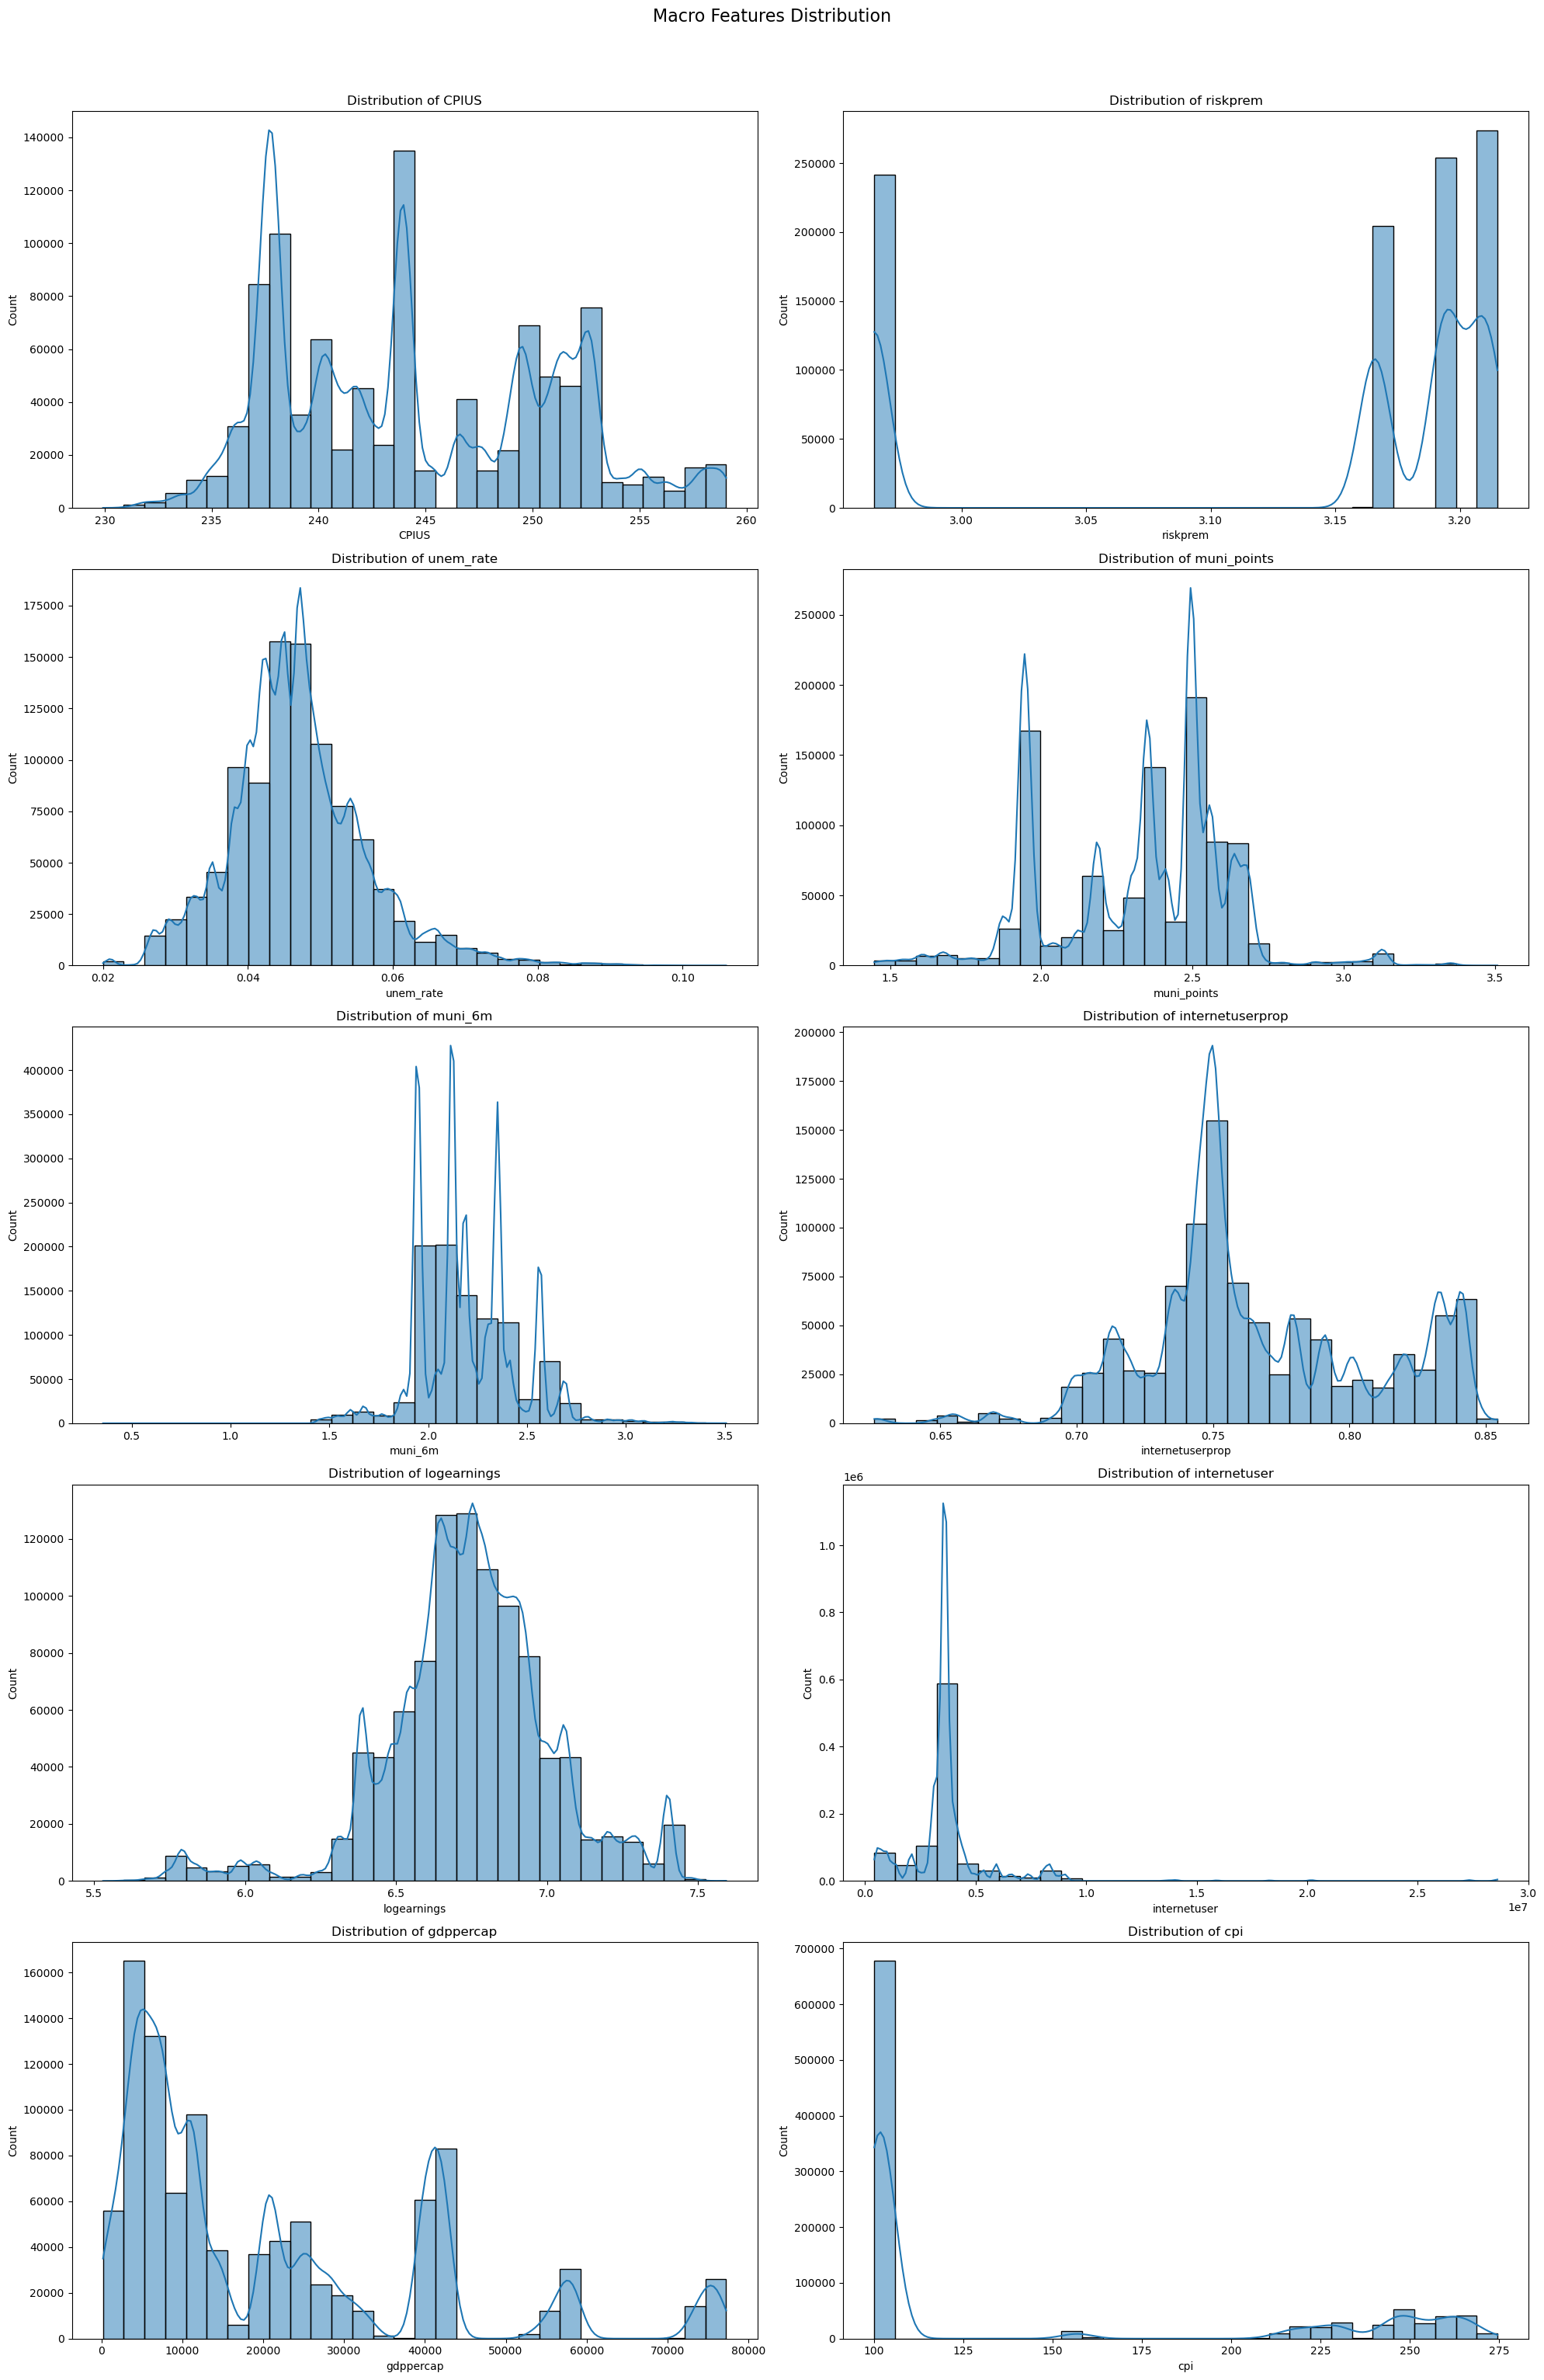

In [374]:
# Determine the number of rows needed for the plots
num_rows = math.ceil(len(macro_features) / 2)

# Create a figure and axes with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows))

# Flatten the axes for easy iteration
axs = axs.flatten()

for i, col in enumerate(macro_features):
    sns.histplot(df[col], bins=30, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')

# Remove any unused subplots
if len(macro_features) % 2 != 0:
    fig.delaxes(axs[-1])

fig.suptitle('Macro Features Distribution (Identifying skewed distributions)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

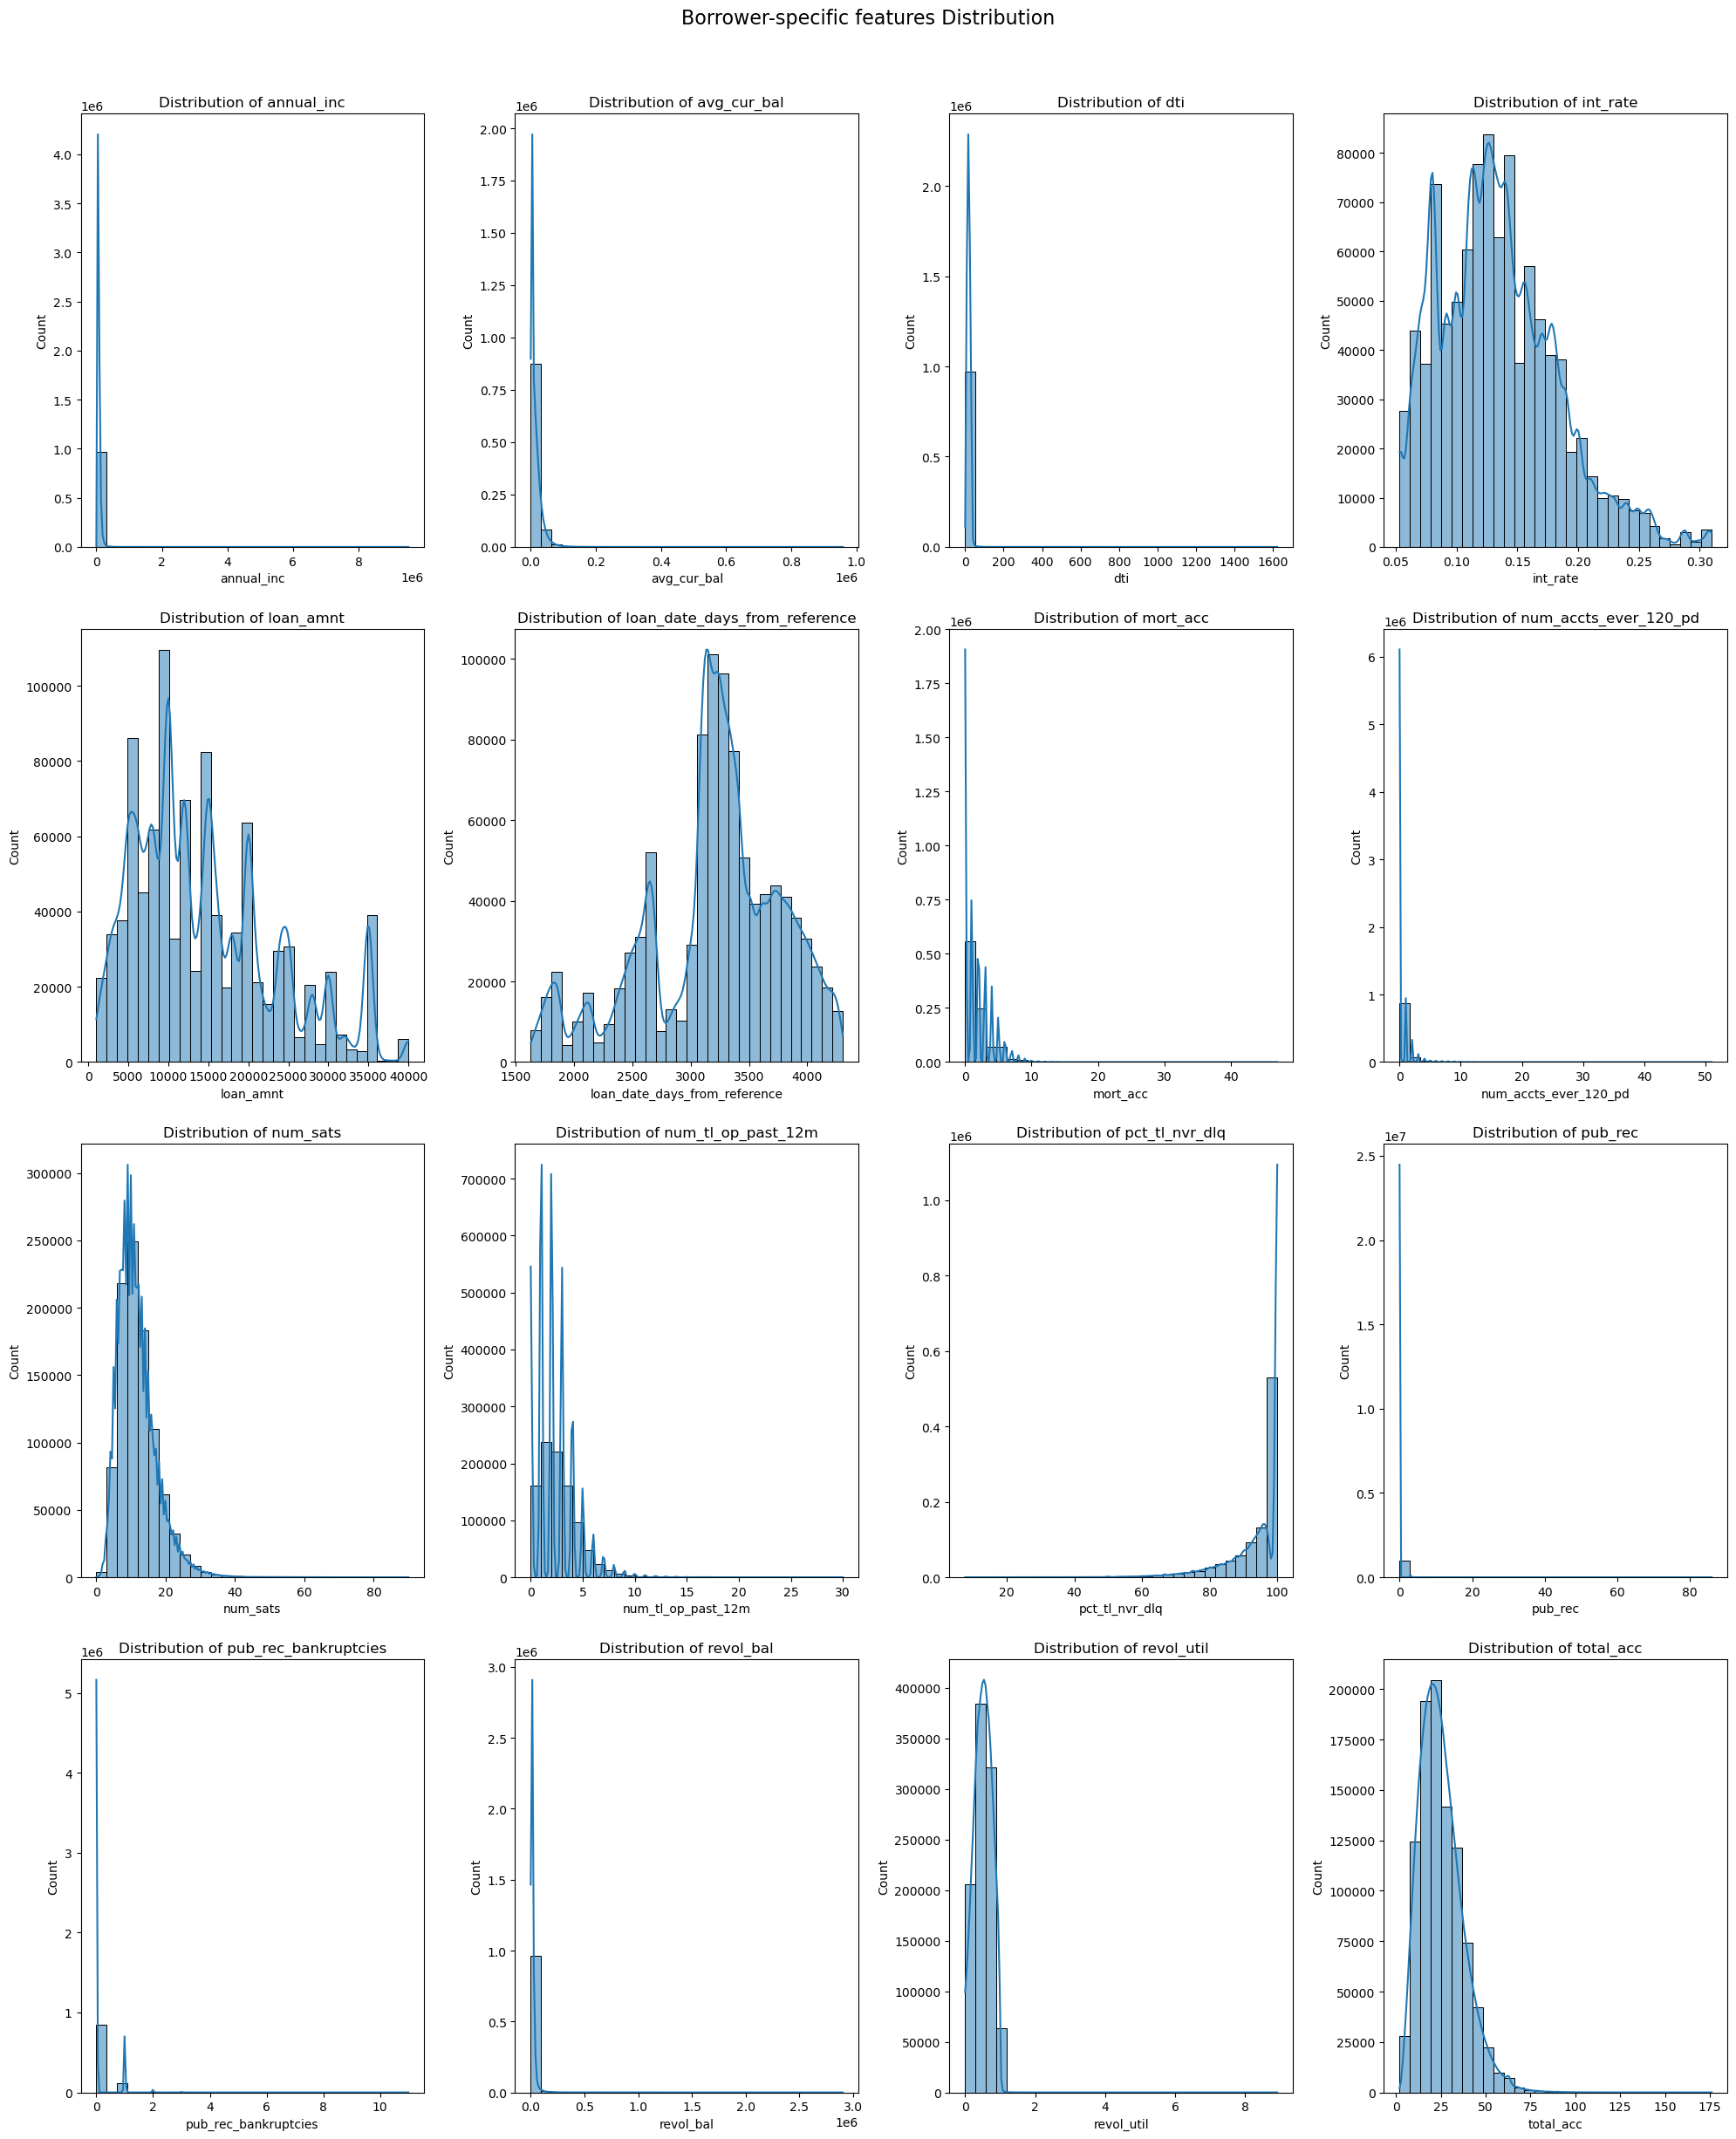

In [375]:
# Determine the number of rows needed for the plots
num_rows = math.ceil(len(numerical_base) / 4)

# Create a figure and axes with subplots
fig, axs = plt.subplots(num_rows, 4, figsize=(20, 6 * num_rows))

# Flatten the axes for easy iteration
axs = axs.flatten()

for i, col in enumerate(numerical_base):
    sns.histplot(df[col], bins=30, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')

# Remove any unused subplots
if len(numerical_base) % 4 != 0:
    for i in range(len(numerical_base), 4 * num_rows):
        fig.delaxes(axs[i])
fig.suptitle('Borrower-specific features Distribution (Identifying skewed distributions)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

In [471]:
def preprocess_data(df, include_macro=True):
    categorical_cols = ['addr_state', 'purpose', 'term_clean', 'sub_grade', 
                        'verification_status', 'grade', 'home_ownership', 
                        'initial_list_status', 'application_type']
    base_numerical_cols = ['annual_inc', 'avg_cur_bal', 'dti', 'int_rate', 
                           'loan_amnt', 'loan_date_days_from_reference', 'mort_acc', 
                           'num_accts_ever_120_pd', 'num_sats', 'num_tl_op_past_12m', 
                           'pct_tl_nvr_dlq', 'pub_rec', 'pub_rec_bankruptcies', 
                           'revol_bal', 'revol_util', 'total_acc']

    # Including macroeconomic features (if specified)
    macro_features = ['CPIUS', 'riskprem', 'unem_rate', 'muni_points', 'muni_6m', 
                      'internetuserprop', 'logearnings', 'internetuser', 'gdppercap', 'cpi'] if include_macro else []
    numerical_cols = base_numerical_cols + macro_features

    log_cols = ['annual_inc', 'avg_cur_bal', 'loan_amnt', 'num_accts_ever_120_pd', 
                'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'revol_bal']

    if include_macro:
        log_cols += ['gdppercap', 'internetuser', 'muni_6m', 'muni_points', 'unem_rate']

    def selective_log(X):
        X_ = X.copy()
        log_cols_present = [col for col in log_cols if col in X_.columns]
        X_[log_cols_present] = np.log1p(X_[log_cols_present])
        return X_

    log_transformer = FunctionTransformer(selective_log, validate=False)

    # Preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('log', log_transformer),
        ('scaler', RobustScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X = df.drop('loan_status_target_variable', axis=1)
    y = df['loan_status_target_variable']
    X_processed = preprocessor.fit_transform(X)

    # Extracting  feature names
    feature_names = numerical_cols + list(preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols))
    
    return X_processed, y, preprocessor, feature_names

# LOGISTIC REGRESSION

In [377]:
#Trainning a subset of the data for develpment stage due to computational constraints
#subset_fraction = 0.5 
#df_subset, further_test = train_test_split(df, test_size=(1 - subset_fraction), stratify=df['loan_status_target_variable'], random_state=42)

In [378]:
#df = df_subset
df.shape

(974317, 36)

In [472]:
X, y, preprocessor, feature_names = preprocess_data(df, include_macro=False)
print(X.shape)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor

(974317, 135)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<function preprocess_data.<locals>.selective_log at 0x2caf956c0>)),
                                                 ('scaler', RobustScaler())]),
                                 ['annual_inc', 'avg_cur_bal', 'dti',
                                  'int_rate', 'loan_amnt',
                                  'loan_date_days_from_reference', 'mort_acc',
                                  'num_accts_ever_120_pd', 'num_sats',
                                  'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
                                  'pub_rec', 'pub_rec_bankruptcies',
                                  'revol_bal', 'revol_util', 'total_acc']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['addr_state', 'purpose', 'term_clean',
                                  'sub_grade', 'verification_status', 'grade',
                                  'home_ownership', 'initial_list_status',
                                  'application_type'])])

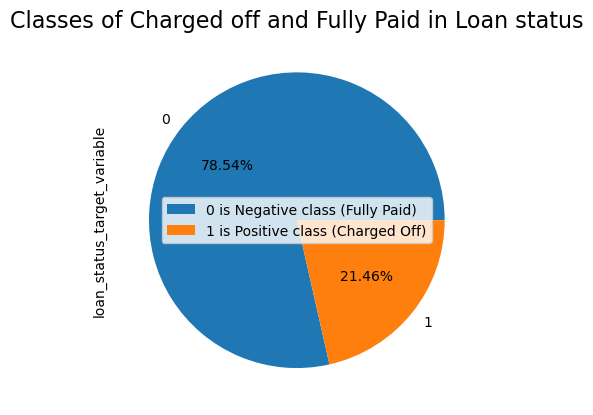

In [380]:
y.value_counts().plot.pie(autopct='%.2f%%')
plt.title('Classes of Charged off and Fully Paid in Loan status', fontsize=16)
plt.legend(labels=['0 is Negative class (Fully Paid)', '1 is Positive class (Charged Off)']) 

__==> The Dataset is imbalanced__ (either with or without macro features), We will need to use some imbalance handling techniques

In [473]:
# Baseline model
model_logistic_base = LogisticRegression(max_iter=1000, random_state=42)
model_logistic_base.fit(X_train_base, y_train_base)
y_pred_base = model_logistic_base.predict(X_test_base)
y_pred_proba_base = model_logistic_base.predict_proba(X_test_base)[:, 1]


In [474]:
# Evaluating the model
print(classification_report(y_test_base, y_pred_base))
print(confusion_matrix(y_test_base, y_pred_base))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test_base, y_pred_proba_base)
print('ROC AUC score:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.98      0.88    153048
           1       0.55      0.09      0.16     41816

    accuracy                           0.79    194864
   macro avg       0.68      0.54      0.52    194864
weighted avg       0.75      0.79      0.72    194864

[[149924   3124]
 [ 37959   3857]]
ROC AUC score: 0.7199254076932261


In [383]:
def evaluate_model(model, X_test, y_test):
    """
    Model Evaluation function to display evaluation metrics and plots.
    
    Parameters:
        - model: The trained machine learning model.
        - X_test (DataFrame): Test features.
        - y_test (Series): True labels for test data.
    """
    # ROC-AUC score
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print("ROC-AUC Score:", roc_auc)

    # Precision-Recall curve 
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    print("Precision-Recall AUC:", pr_auc)

    # F1 scores from precision and recall
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal threshold by F1:", optimal_threshold)

    # for 1x3 subplot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[0])
    ax[0].set_title('ROC Curve')
    
    # Confusion Matrix at Normal Threshold (0.5)
    y_pred_normal = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_normal)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1])
    ax[1].set_title('Confusion Matrix at Threshold 0.5')

    # Precision and Recall vs Threshold
    ax[2].plot(thresholds, precision[:-1], 'b--', label='Precision (class=1)')
    ax[2].plot(thresholds, recall[:-1], 'g-', label='Recall (class=1)')
    ax[2].set_ylabel('Precision | Recall')
    ax[2].set_xlabel('Threshold')
    ax[2].set_title('Precision and Recall Scores as function of threshold')
    ax[2].axvline(x=0.5, color='k', linestyle='--', label='Threshold at 0.5')
    ax[2].axhline(y=0.5, color='r', linestyle='--', label='Score at 0.5')
    ax[2].legend(loc='best')

    plt.tight_layout()
    plt.show()
    
    return precision, recall, thresholds


ROC-AUC Score: 0.7199254076932261
Precision-Recall AUC: 0.4033859378614958
Optimal threshold by F1: 0.9999366579773307


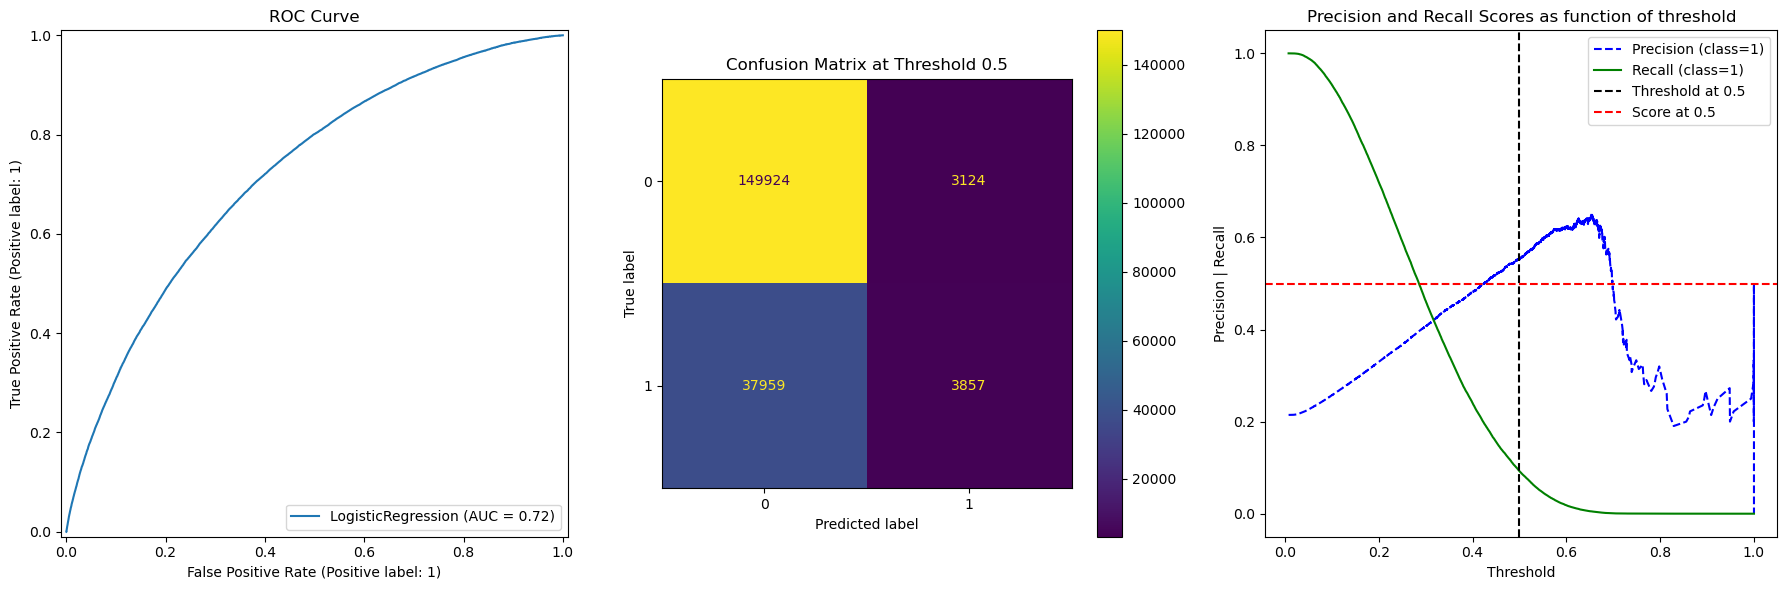

In [384]:
precision, recall, thresholds = evaluate_model(model_logistic_base, X_test_base, y_test_base)

In [385]:
## Hyperparameter tuning

param_grid = {
    'C': [0.1, 1, 10, 100]}

grid_search = GridSearchCV(model_logistic_base, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_base, y_train_base)
model_best_logistic_base = grid_search.best_estimator_
model_best_logistic_base

LogisticRegression(C=0.1, max_iter=1000, random_state=42)

In [386]:
y_pred_proba_best_base = model_best_logistic_base.predict_proba(X_test_base)[:, 1]
# Evaluating the model
y_pred_best_base = model_best_logistic_base.predict(X_test_base)

print(classification_report(y_test_base, y_pred_best_base))
print(confusion_matrix(y_test_base, y_pred_best_base))

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test_base, y_pred_proba_best_base)
print('ROC AUC score:', roc_auc)

              precision    recall  f1-score   support

           0       0.80      0.98      0.88    153048
           1       0.55      0.09      0.16     41816

    accuracy                           0.79    194864
   macro avg       0.68      0.54      0.52    194864
weighted avg       0.75      0.79      0.72    194864

[[149929   3119]
 [ 37970   3846]]
ROC AUC score: 0.7199265149057823


- Evaluating with cross validation for robustness of results


In [212]:
cv_scores = cross_val_score(model_best_logistic_base, X_train_base, y_train_base, cv=10, scoring='roc_auc')
print("Cross-validation AUC-ROC scores:", cv_scores)
print("Mean AUC-ROC:", cv_scores.mean())

Cross-validation AUC-ROC scores: [0.71899074 0.72161473 0.72309252 0.71961376 0.71537197 0.71986272
 0.71803645 0.71992075 0.72178809 0.72321605]
Mean AUC-ROC: 0.7201507783544912


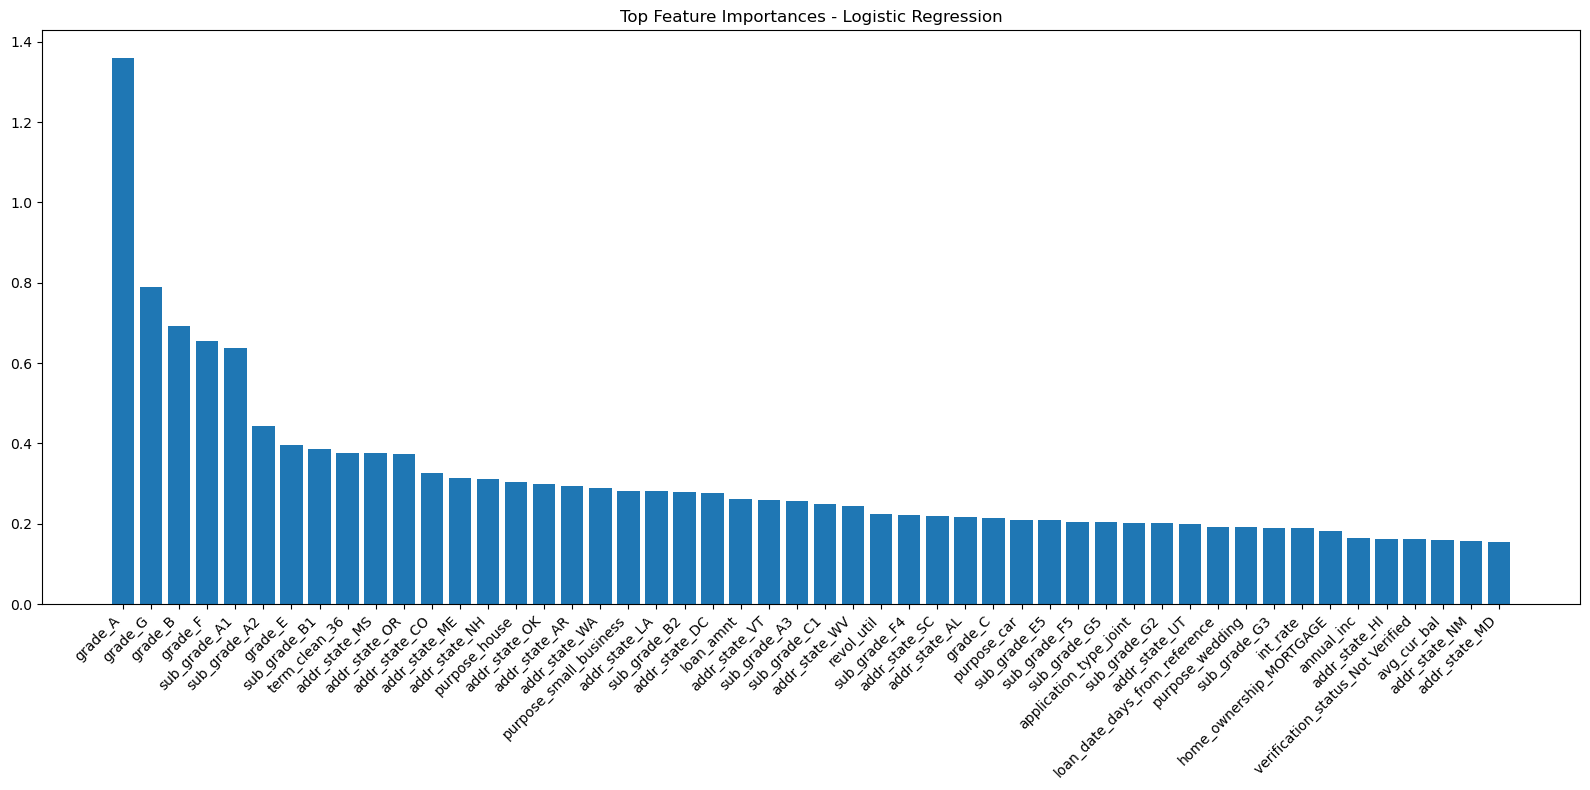

In [475]:
# feature importance DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': abs(model_logistic_base.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot the top 10 feature importances
plt.figure(figsize=(16, 8))
plt.bar(feature_importance['feature'][:50], feature_importance['importance'][:50])
plt.title('Top Feature Importances - Logistic Regression')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## __Adjusting Class Weights in Logistic Regression:__
Involves giving a higher weight to the minority class so that the classifier pays more attention to getting these instances correct.
1. __Manually__
2. __Using compute_class_weight from sklearn.utils.class_weight to automatically determine them based on the inverse of class frequencies.__

Using class_weight='balanced'
By setting class_weight='balanced', the logistic regression model will apply weights to the classes as follows:
weight_i = (n_samples) / (n_classes × n_i)

- ​weight_i = the weight for class i

- 𝑛_samples =  the total number of samples/ occurences,
 
- 𝑛_classes =  the number of unique classes,
​- n_i = total number of samples/ occurences, in class i
 
​
__This adjustment means that misclassifying a sample from Class 1 is considered 10 times more costly than misclassifying a sample from Class 0__



In [476]:
# class_weight='balanced')
model_logistic_class_weights_1_balanced = LogisticRegression(C= 0.1, class_weight='balanced').fit(X_train_base, y_train_base)
y_pred_proba_logistic_class_weights_1_balanced = model_logistic_class_weights_1_balanced.predict_proba(X_test_base)[:, 1]
y_pred_logistic_class_weights_1_balanced = model_logistic_class_weights_1_balanced.predict(X_test_base)

print("logistic model - class_weights('balanced')")
print(classification_report(y_test_base, y_pred_logistic_class_weights_1_balanced))
print(confusion_matrix(y_test_base, y_pred_logistic_class_weights_1_balanced))

# Custom weighting
model_logistic_class_weights_2_manual = LogisticRegression(C= 0.1,class_weight={0:1, 1:10}).fit(X_train_base, y_train_base)

y_pred_logistic_class_weights_2_manual = model_logistic_class_weights_2_manual.predict(X_test_base)

print("\nlogistic model - class_weights(manual {0:1, 1:10} )")
print(classification_report(y_test_base, y_pred_logistic_class_weights_2_manual))
print(confusion_matrix(y_test_base, y_pred_logistic_class_weights_2_manual))

logistic model - class_weights('balanced')
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    153048
           1       0.34      0.68      0.46     41816

    accuracy                           0.65    194864
   macro avg       0.61      0.66      0.60    194864
weighted avg       0.77      0.65      0.68    194864

[[97993 55055]
 [13248 28568]]

logistic model - class_weights(manual {0:1, 1:10} )
              precision    recall  f1-score   support

           0       0.94      0.23      0.37    153048
           1       0.25      0.95      0.40     41816

    accuracy                           0.38    194864
   macro avg       0.60      0.59      0.38    194864
weighted avg       0.79      0.38      0.38    194864

[[ 35212 117836]
 [  2286  39530]]


ROC-AUC Score: 0.7202406704526223
Precision-Recall AUC: 0.4032591680174341
Optimal threshold by F1: 0.9999987084588863


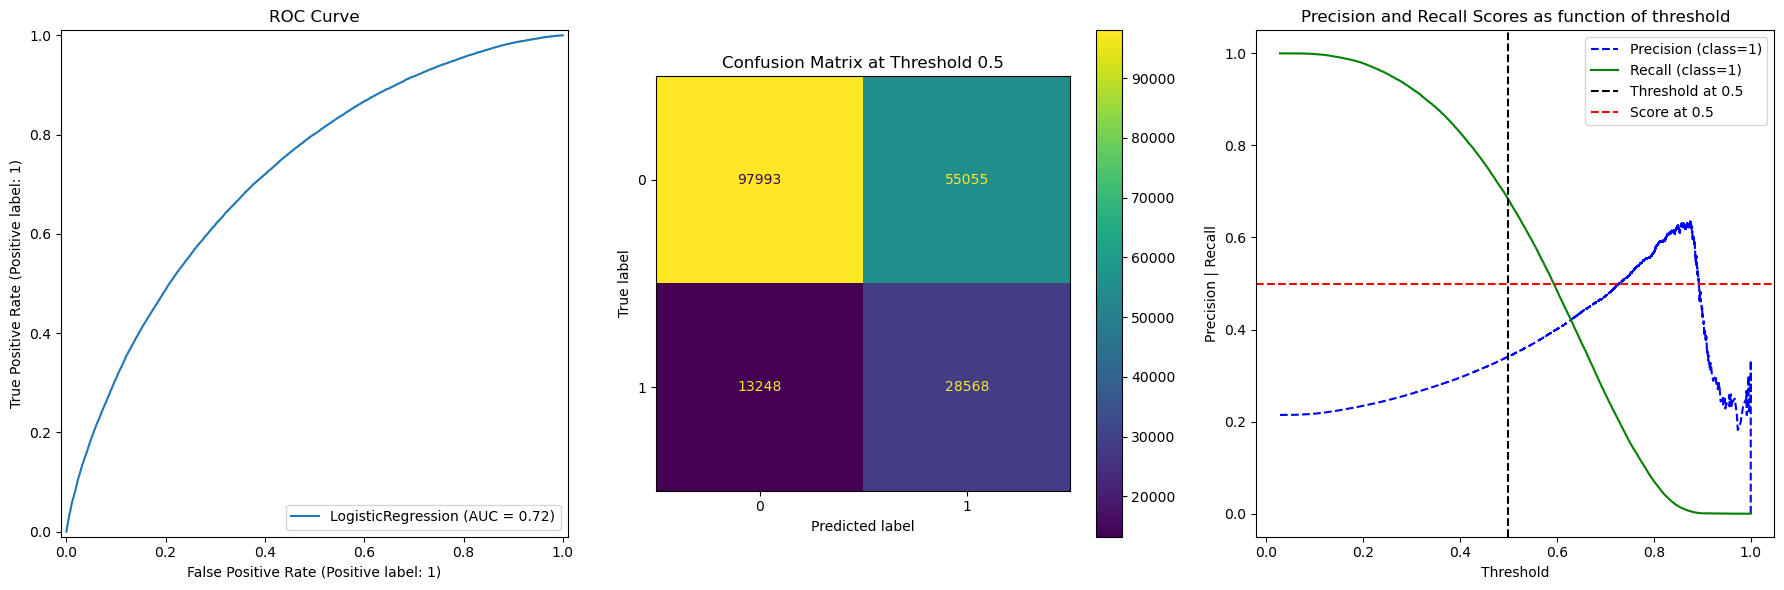

In [389]:
evaluate_model(model_logistic_class_weights_1_balanced, X_test_base, y_test_base);

In [249]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_base), y=y_train_base)
class_weight_dict = dict(zip(np.unique(y_train_base), class_weights))
model_logistic_class_weights_compute = LogisticRegression(class_weight=class_weight_dict).fit(X_train_base, y_train_base) # Model fitting with computed class weights

y_pred_logistic_class_weights_3_compute = model_logistic_class_weights_compute.predict(X_test_base)

print("\nlogistic model - Model fitting with computed class weights )")
print(classification_report(y_test_base, y_pred_logistic_class_weights_3_compute))
print(confusion_matrix(y_test_base, y_pred_logistic_class_weights_3_compute))



logistic model - Model fitting with computed class weights )
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    153048
           1       0.34      0.68      0.46     41816

    accuracy                           0.65    194864
   macro avg       0.61      0.66      0.60    194864
weighted avg       0.77      0.65      0.68    194864

[[97896 55152]
 [13225 28591]]


In [255]:
print("Before threshold adjustment - (Logistic model - Base model \n" + "-" *54)
print(classification_report(y_test_base, y_pred_base))
print(confusion_matrix(y_test_base, y_pred_base))

print("After adjusting the class weights - Base \n" + "-" *54)
print(classification_report(y_test_base, y_pred_logistic_class_weights_1_balanced))
print(confusion_matrix(y_test_base, y_pred_logistic_class_weights_1_balanced))

Before threshold adjustment - (Logistic model - Base model 
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.98      0.88    153048
           1       0.55      0.09      0.16     41816

    accuracy                           0.79    194864
   macro avg       0.68      0.54      0.52    194864
weighted avg       0.75      0.79      0.72    194864

[[149924   3124]
 [ 37959   3857]]
After adjusting the class weights - Base 
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    153048
           1       0.34      0.68      0.46     41816

    accuracy                           0.65    194864
   macro avg       0.61      0.66      0.60    194864
weighted avg       0.77      0.65      0.68    194864

[[97993 55055]
 [13248 28568]]


__==> Overall accuracy continued to decrease however Recall(1) has improved even more significantly (we focus on recall)__ 

ROC-AUC Score: 0.7202406704526223
Precision-Recall AUC: 0.4032591680174341
Optimal threshold by F1: 0.9999987084588863


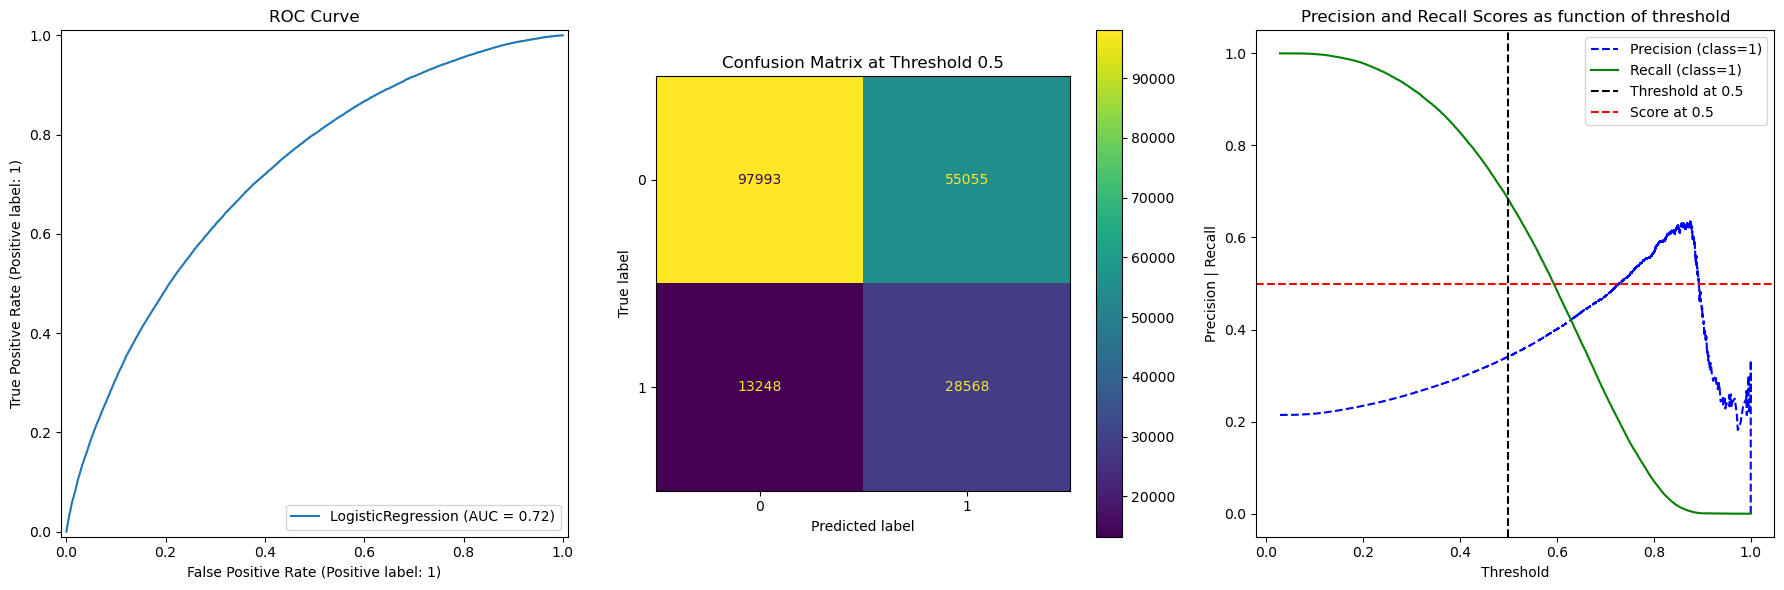

In [251]:
evaluate_model(model_logistic_class_weights_1_balanced, X_test_base, y_test_base);

In [258]:
# Due to the surge in accuracy, recall, without downfall of auc we can finally use the class_weight='balanced' parameter in the LogisticRegression model as our baseline model.
y_pred_proba_base = y_pred_proba_logistic_class_weights_1_balanced
y_pred_base = y_pred_logistic_class_weights_1_balanced
model_logistic_base = model_logistic_class_weights_1_balanced

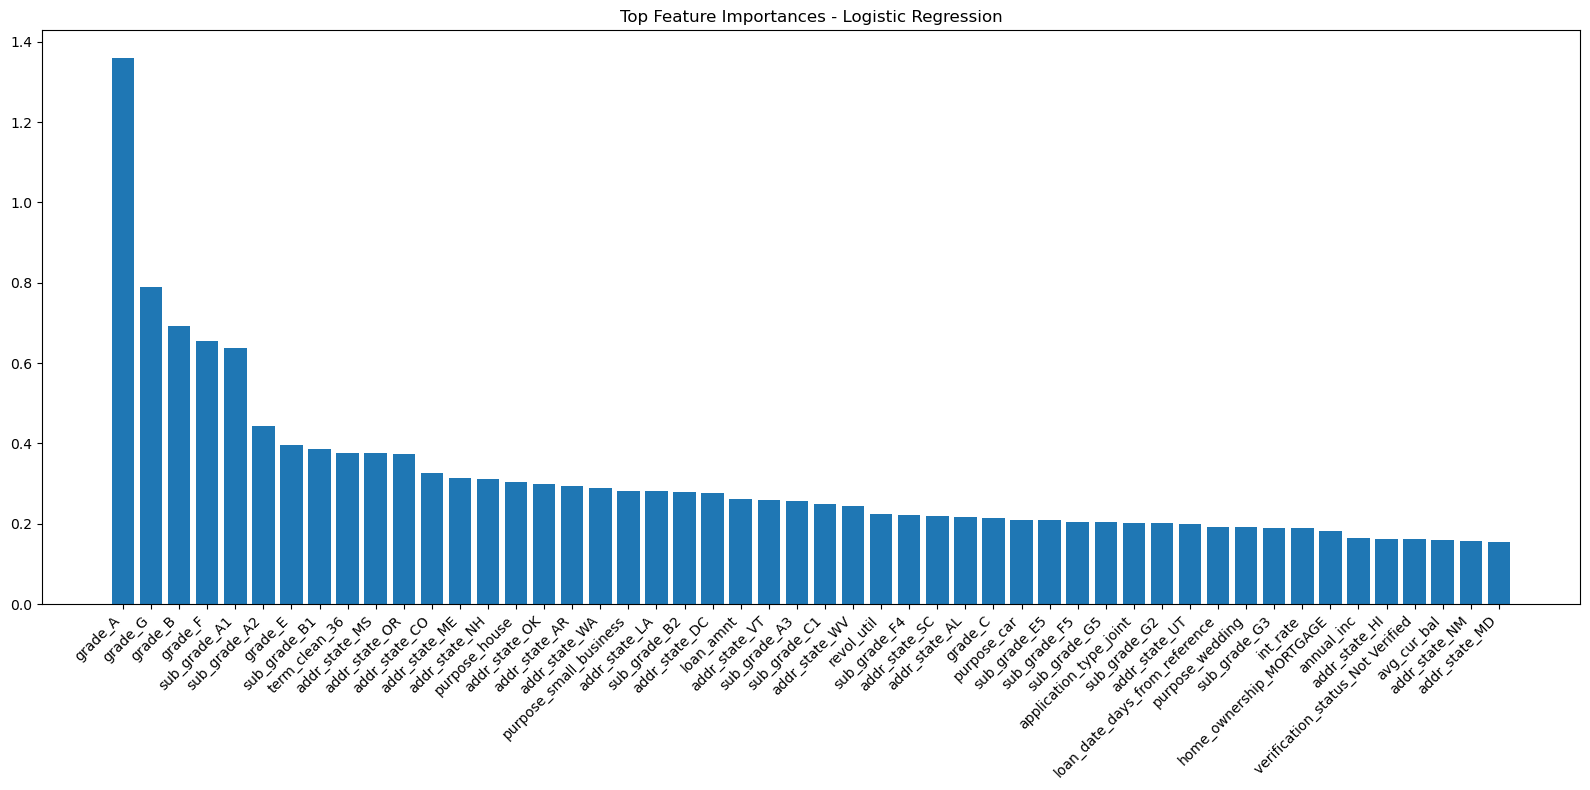

In [477]:
# feature importance DataFrame
feature_importance_logistic_balanced_1 = pd.DataFrame({
    'feature': feature_names,
    'importance': abs(model_logistic_class_weights_1_balanced.coef_[0])
})
feature_importance_logistic_balanced = feature_importance_logistic_balanced_1.sort_values('importance', ascending=False)

# Plot the top 10 feature importances
plt.figure(figsize=(16, 8))
plt.bar(feature_importance['feature'][:50], feature_importance['importance'][:50])
plt.title('Top Feature Importances - Logistic Regression')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Calibration techniques

- Calibration primarily adjusts the probability estimates, not the final binary predictions. It aims to make these probabilities more accurate reflections of true probabilities.
- Calibration can change some predictions from 0 to 1 or vice versa. This happens if the calibration moves a probability across the decision threshold.
- Calibration generally preserves the ranking of predictions. This means if instance A had a higher probability than instance B before calibration, it will typically still have a higher probability after calibration.

__Impact on metrics:__

- Rank-based metrics like AUC-ROC usually remain unchanged.
- Threshold-dependent metrics like accuracy, precision, recall might change if probabilities cross the decision threshold.
- Probability-based metrics like log-loss or Brier score often improve significantly.





- Calibration: Check and potentially improve probability calibration:



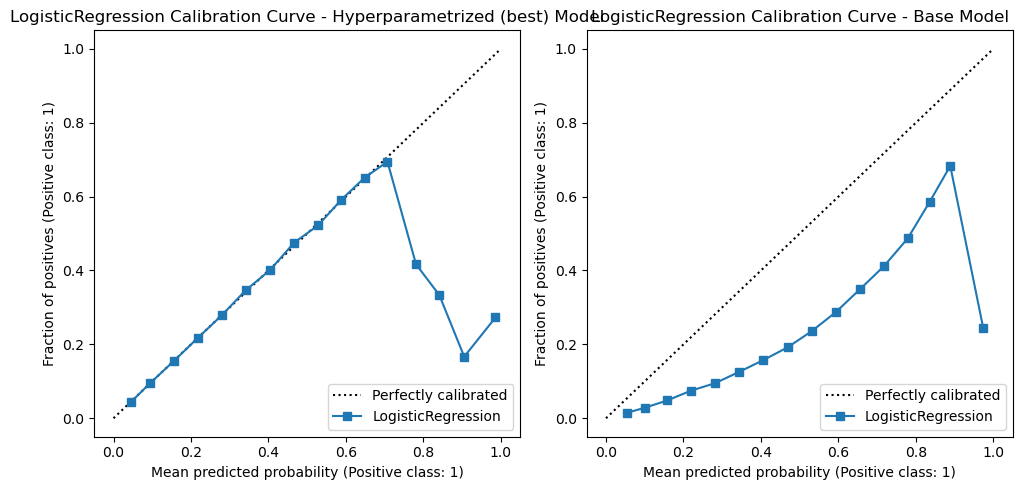

In [259]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Calibration curve for the best model
disp = CalibrationDisplay.from_estimator(estimator=model_best_logistic_base, X=X_test_base, y=y_test_base, n_bins=16, ax=axs[0])
axs[0].set_title('LogisticRegression Calibration Curve - Hyperparametrized (best) Model')

# Calibration curve for the base model
disp = CalibrationDisplay.from_estimator(estimator=model_logistic_base, X=X_test_base, y=y_test_base, n_bins=16, ax=axs[1])
axs[1].set_title('LogisticRegression Calibration Curve - Base Model')

plt.tight_layout()
plt.show()

- __The calibration curves for both models look very similar, suggesting that hyperparametrization didn't significantly improve calibration__
- __The models perform well for lower and mid-range probabilities but struggle with higher probabilities.__
- __The sharp fluctuations in the higher probability range (0.7-1.0) suggest potential overfitting or issues with the dataset for high-risk predictions.__


### Calibration Classifiers

In [260]:
#PLATT SCALING
calibrated_model_platt_scaling = CalibratedClassifierCV(estimator=model_logistic_base, method='sigmoid', cv=5)
calibrated_model_platt_scaling.fit(X_train_base, y_train_base)
calibrated_proba_platt_scaling = calibrated_model_platt_scaling.predict_proba(X_test_base)[:, 1]

calibrated_model_platt_scaling


CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=0.1,
                                                    class_weight='balanced'))

In [261]:
# Isotonic Regression: Non-parametric method that fits a piecewise-constant function to calibrate probabilities.
calibrated_model_isotonic = CalibratedClassifierCV(estimator=model_logistic_base, method='isotonic', cv=5)
calibrated_model_isotonic.fit(X_train_base, y_train_base)
calibrated_proba_isotonic = calibrated_model_isotonic.predict_proba(X_test_base)[:, 1]


calibrated_model_isotonic

CalibratedClassifierCV(cv=5,
                       estimator=LogisticRegression(C=0.1,
                                                    class_weight='balanced'),
                       method='isotonic')

In [262]:
# beta calibration
calibrated_model_beta = BetaCalibration()
calibrated_model_beta.fit(model_logistic_base.predict_proba(X_train_base)[:,1], y_train_base)
calibrated_proba_beta_calibration = calibrated_model_beta.predict(model_logistic_base.predict_proba(X_test_base)[:,1])

calibrated_model_beta

BetaCalibration()

In [263]:
# Function to evaluate the calibration of the model
def plot_calibration_curves(y_true, probs_list, names, n_bins=16):
    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    
    for probs, name in zip(probs_list, names):
        prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=n_bins)
        plt.plot(prob_pred, prob_true, marker='o', label=name)
    
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

def plot_roc_curves(y_true, probs_list, names):
    plt.figure(figsize=(8, 8))
    for probs, name in zip(probs_list, names):
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

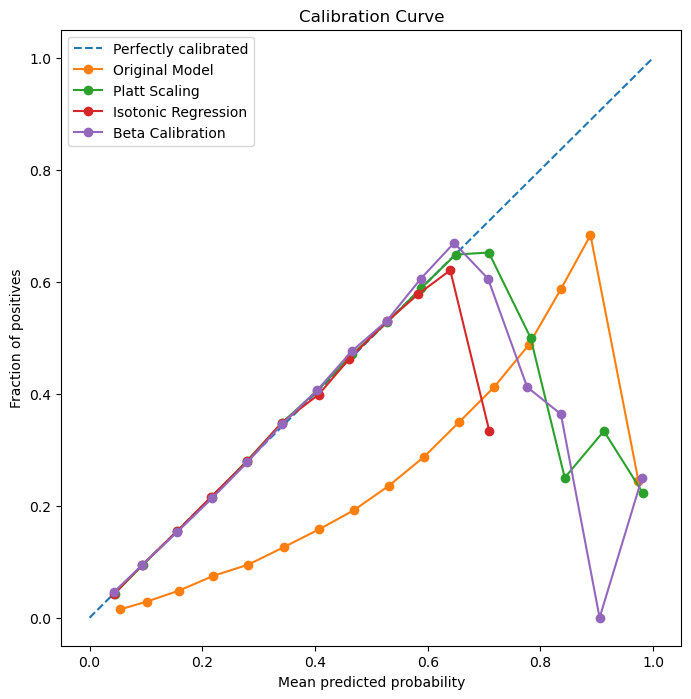

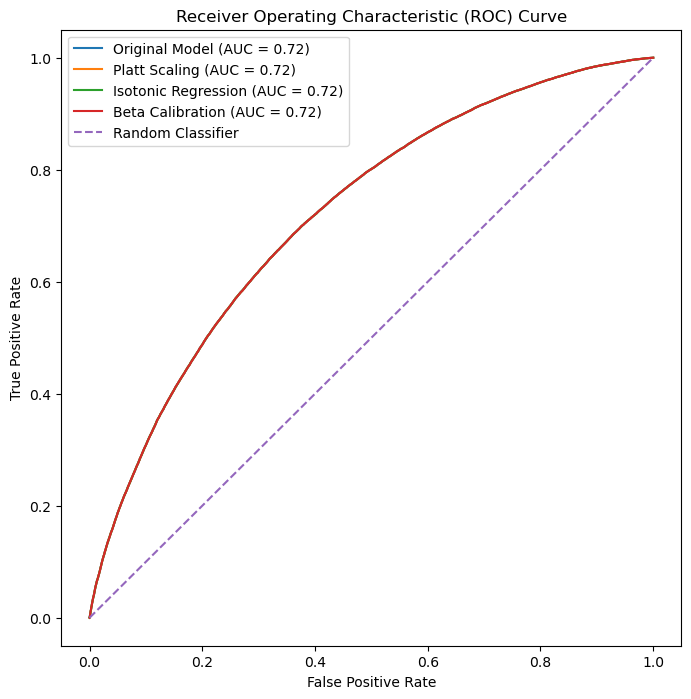

<Figure size 640x480 with 0 Axes>

In [264]:
# Calibration curves
plot_calibration_curves(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, calibrated_proba_beta_calibration],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 'Beta Calibration']
)

# ROC curves
plot_roc_curves(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, calibrated_proba_beta_calibration],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 'Beta Calibration']
)
plt.suptitle('Calibration and ROC Curves for Logistic Regression Model', fontsize=16)
plt.tight_layout()
plt.show()

In [265]:
from sklearn.metrics import brier_score_loss, log_loss

def evaluate_calibration(y_true, probs_list, names):
    for probs, name in zip(probs_list, names):
        brier = brier_score_loss(y_true, probs)
        log_loss_score = log_loss(y_true, probs)
        print(f"{name}:")
        print(f"  Brier Score: {brier:.4f}")
        print(f"  Log Loss: {log_loss_score:.4f}")
        print()

# Evaluating all models
evaluate_calibration(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, calibrated_proba_beta_calibration],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 'Beta Calibration']
)

Original Model:
  Brier Score: 0.2146
  Log Loss: 0.6165

Platt Scaling:
  Brier Score: 0.1508
  Log Loss: 0.4676

Isotonic Regression:
  Brier Score: 0.1508
  Log Loss: 0.4672

Beta Calibration:
  Brier Score: 0.1508
  Log Loss: 0.4676



In [266]:
from scipy.optimize import minimize

class TemperatureScaling:
    def __init__(self, model):
        self.model = model
        self.temperature = 1.0

    def _log_loss(self, temperature, logits, true_labels):
        temp_scaled_probs = self._temperature_scale(logits, temperature)
        loss = -np.mean(true_labels * np.log(temp_scaled_probs + 1e-10) + 
                        (1 - true_labels) * np.log(1 - temp_scaled_probs + 1e-10))
        return loss

    def _temperature_scale(self, logits, temperature):
        return 1 / (1 + np.exp(-logits / temperature))

    def fit(self, X_val, y_val):
        logits = self.model.decision_function(X_val)
        opt = minimize(self._log_loss, x0=1.0, args=(logits, y_val), method='nelder-mead')
        self.temperature = opt.x[0]

    def predict_proba(self, X):
        logits = self.model.decision_function(X)
        temp_scaled_probs = self._temperature_scale(logits, self.temperature)
        return np.vstack((1-temp_scaled_probs, temp_scaled_probs)).T

Optimal temperature: 1.0382


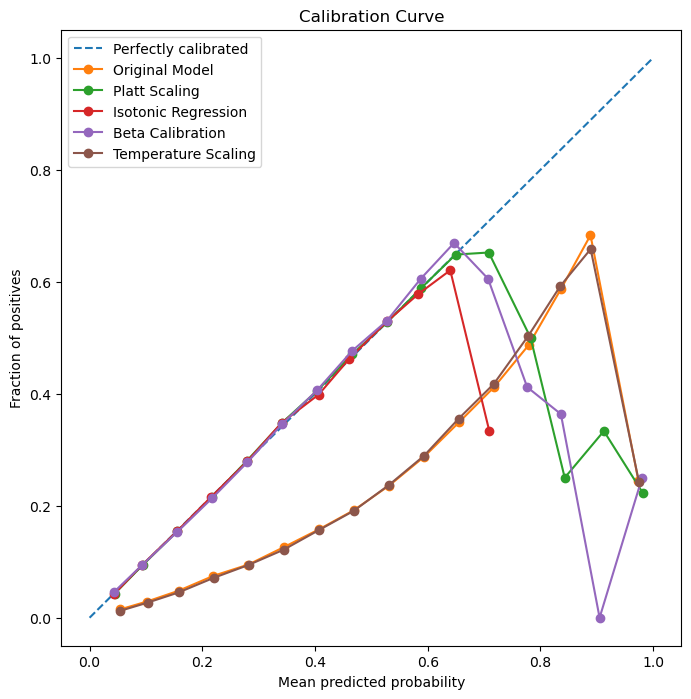

Original Model:
  Brier Score: 0.2146
  Log Loss: 0.6165

Platt Scaling:
  Brier Score: 0.1508
  Log Loss: 0.4676

Isotonic Regression:
  Brier Score: 0.1508
  Log Loss: 0.4672

Beta Calibration:
  Brier Score: 0.1508
  Log Loss: 0.4676

Temperature Scaling:
  Brier Score: 0.2145
  Log Loss: 0.6164



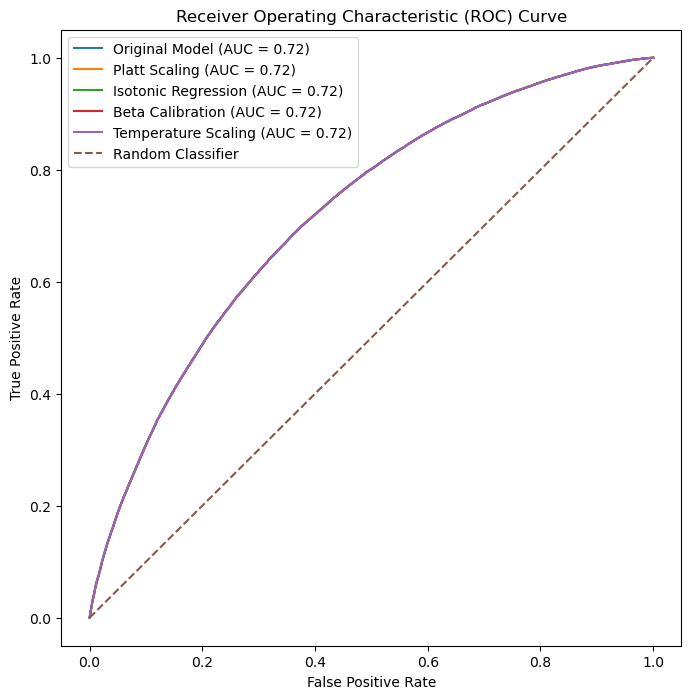

In [267]:
# Initialization and fitting the Temperature Scaling calibrator
calibrated_model_temperature_scaling = TemperatureScaling(model_logistic_base)
calibrated_model_temperature_scaling.fit(X_train_base, y_train_base)

#  calibrated probabilities
calibrated_proba_temp_scaling = calibrated_model_temperature_scaling.predict_proba(X_test_base)[:, 1]

# the optimal temperature
print(f"Optimal temperature: {calibrated_model_temperature_scaling.temperature:.4f}")

# evaluation 
plot_calibration_curves(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, 
     calibrated_proba_beta_calibration, calibrated_proba_temp_scaling],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 
     'Beta Calibration', 'Temperature Scaling']
)

evaluate_calibration(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, 
     calibrated_proba_beta_calibration, calibrated_proba_temp_scaling],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 
     'Beta Calibration', 'Temperature Scaling']
)

plot_roc_curves(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, 
     calibrated_proba_beta_calibration, calibrated_proba_temp_scaling],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 
     'Beta Calibration', 'Temperature Scaling']
)

In [395]:
f1_score_calibrated_proba_temp_scaling = f1_score(y_test_base, (calibrated_proba_temp_scaling >= 0.5).astype(int))
print(f"F1 Score for Temperature Scaling calibrated model: {f1_score_calibrated_proba_temp_scaling:.4f}")

F1 Score for Temperature Scaling calibrated model: 0.4555


__==> Not much improvement in the calibration of the model.__

### Hybrid and Custom Approaches:
Segment-based Calibration: different calibration methods to different probability ranges.

__Rationale:__ This approach recognizes that different probability ranges might benefit from different calibration methods. It's particularly useful when your model's calibration varies across the probability spectrum, which is common in many real-world scenarios, including credit risk modeling.

What we're doing here:

- Segmenting the probability space: dividing the probability range into three segments:

    - Low risk: probabilities < 0.3
    - Medium risk: probabilities between 0.3 and 0.7
    - High risk: probabilities >= 0.7


- Applying different calibration methods to each segment:
    - Low risk: Isotonic Regression
    - Medium risk: Beta Calibration
    - High risk: Platt Scaling (Sigmoid calibration)


__The rationale__ behind this is that different methods might work better for different probability ranges. For instance, Isotonic Regression is non-parametric and can handle various shapes of miscalibration, which might be suitable for the low-risk range where the relationship between predicted and true probabilities could be complex. Beta Calibration is flexible and often works well for both sigmoid and S-shaped miscalibrations, making it a good choice for the middle range. Platt Scaling is simple and often effective for the extremes, hence its use in the high-risk range.

In [268]:
class SegmentCalibrator(BaseEstimator, ClassifierMixin):
    def __init__(self, low_threshold=0.3, high_threshold=0.7):
        self.low_threshold = low_threshold
        self.high_threshold = high_threshold
        self.cal_low = None
        self.cal_mid = None
        self.cal_high = None

    def fit(self, probs, y_true):
        low_mask = probs < self.low_threshold
        mid_mask = (probs >= self.low_threshold) & (probs < self.high_threshold)
        high_mask = probs >= self.high_threshold

        if np.sum(low_mask) > 0:
            base_low = LogisticRegression()
            base_low.fit(probs[low_mask].reshape(-1, 1), y_true[low_mask])
            self.cal_low = CalibratedClassifierCV(estimator=base_low, method='isotonic', cv=5)
            self.cal_low.fit(probs[low_mask].reshape(-1, 1), y_true[low_mask])
        
        if np.sum(mid_mask) > 0:
            self.cal_mid = BetaCalibration()
            self.cal_mid.fit(probs[mid_mask], y_true[mid_mask])
        
        if np.sum(high_mask) > 0:
            base_high = LogisticRegression()
            base_high.fit(probs[high_mask].reshape(-1, 1), y_true[high_mask])
            self.cal_high = CalibratedClassifierCV(estimator=base_high, method='sigmoid', cv=5)
            self.cal_high.fit(probs[high_mask].reshape(-1, 1), y_true[high_mask])

        return self

    def predict_proba(self, probs):
        calibrated_probs = np.zeros_like(probs)
        
        low_mask = probs < self.low_threshold
        mid_mask = (probs >= self.low_threshold) & (probs < self.high_threshold)
        high_mask = probs >= self.high_threshold

        if self.cal_low is not None and np.sum(low_mask) > 0:
            calibrated_probs[low_mask] = self.cal_low.predict_proba(probs[low_mask].reshape(-1, 1))[:, 1]
        
        if self.cal_mid is not None and np.sum(mid_mask) > 0:
            calibrated_probs[mid_mask] = self.cal_mid.predict(probs[mid_mask])
        
        if self.cal_high is not None and np.sum(high_mask) > 0:
            calibrated_probs[high_mask] = self.cal_high.predict_proba(probs[high_mask].reshape(-1, 1))[:, 1]

        return calibrated_probs

# Calibrating the model
calibrated_model_segment_calibrator = SegmentCalibrator()
calibrated_model_segment_calibrator.fit(model_logistic_base.predict_proba(X_train_base)[:, 1], y_train_base)
calibrated_probs_segment = calibrated_model_segment_calibrator.predict_proba(model_logistic_base.predict_proba(X_test_base)[:, 1])

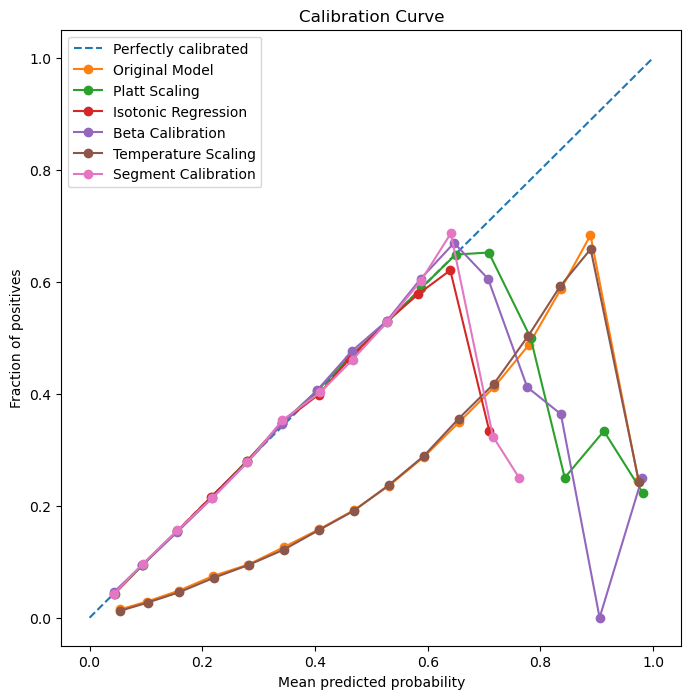

Original Model:
  Brier Score: 0.2146
  Log Loss: 0.6165

Platt Scaling:
  Brier Score: 0.1508
  Log Loss: 0.4676

Isotonic Regression:
  Brier Score: 0.1508
  Log Loss: 0.4672

Beta Calibration:
  Brier Score: 0.1508
  Log Loss: 0.4676

Temperature Scaling:
  Brier Score: 0.2145
  Log Loss: 0.6164

Segment Calibration:
  Brier Score: 0.1508
  Log Loss: 0.4673



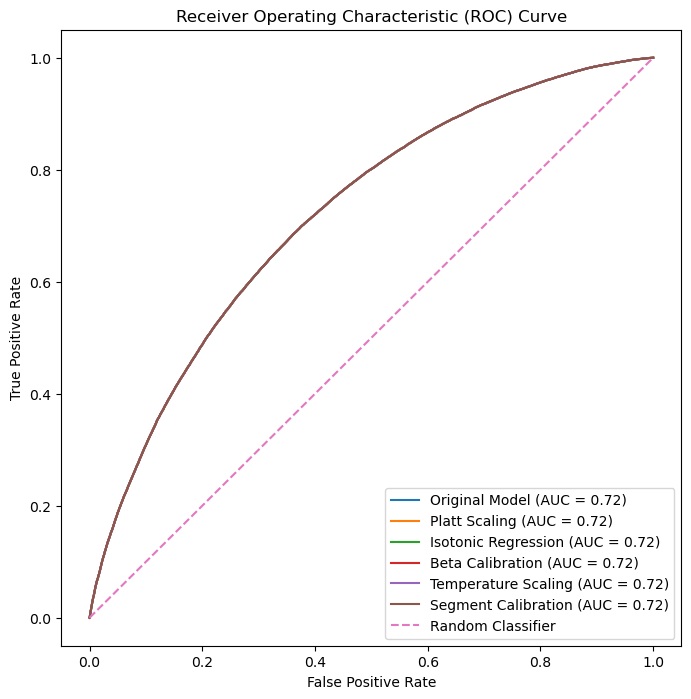

In [269]:
# Adding segment-based calibration for evaluation
plot_calibration_curves(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, 
     calibrated_proba_beta_calibration, calibrated_proba_temp_scaling, calibrated_probs_segment],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 
     'Beta Calibration', 'Temperature Scaling', 'Segment Calibration']
)

evaluate_calibration(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, 
     calibrated_proba_beta_calibration, calibrated_proba_temp_scaling, calibrated_probs_segment],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 
     'Beta Calibration', 'Temperature Scaling', 'Segment Calibration']
)

plot_roc_curves(
    y_test_base,
    [y_pred_proba_base, calibrated_proba_platt_scaling, calibrated_proba_isotonic, 
     calibrated_proba_beta_calibration, calibrated_proba_temp_scaling, calibrated_probs_segment],
    ['Original Model', 'Platt Scaling', 'Isotonic Regression', 
     'Beta Calibration', 'Temperature Scaling', 'Segment Calibration']
)

In [270]:
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """
    Calculate ROC AUC, recall for class 1, and accuracy.

    Parameters:
    - y_test_base: True labels.
    - y_pred_proba: Predicted probabilities for the positive class.
    - threshold: float, Threshold for converting probabilities to class labels.

    Returns:
    - metrics: dict, Dictionary containing ROC AUC, recall for class 1, and accuracy.
    """
    # Convert probabilities to class labels based on the threshold
    y_pred = np.where(y_pred_proba >= threshold, 1, 0)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    recall = recall_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    
    # Return metrics
    metrics = {'ROC AUC': roc_auc, 'Recall (Class 1)': recall, 'Accuracy': accuracy}#, 'F1 Score': f1_score(y_true, y_pred), 'Precision': precision_score(y_true, y_pred)}
    return metrics

In [271]:
calibrated_metrics = []
for proba in [calibrated_proba_platt_scaling, calibrated_proba_isotonic, 
              calibrated_proba_beta_calibration, calibrated_proba_temp_scaling, calibrated_probs_segment]:
    calibrated_metrics.append(calculate_metrics(y_test_base, proba))

print(pd.DataFrame(calibrated_metrics, index=('Platt Scaling', 'Isotonic Regression', 'Beta Calibration', 'Temperature Scaling', 'Segment Calibration')))


                      ROC AUC  Recall (Class 1)  Accuracy
Platt Scaling        0.720243          0.092237  0.789263
Isotonic Regression  0.720232          0.100966  0.789510
Beta Calibration     0.720241          0.083509  0.789037
Temperature Scaling  0.720241          0.683183  0.649484
Segment Calibration  0.720255          0.101301  0.789576


#### Conclusion for Calibration Part:

__Calibration Curve:__

- All calibration methods, including original model, follow the perfectly calibrated line closely for probabilities up to about 0.6.
- There's significant deviation in the 0.7-0.9 range for most methods.
- Segment Calibration (pink line) seems to perform well in the higher probability ranges where others struggle.


__ROC Curve:__

All models, including the original and calibrated versions, have identical AUC scores of 0.72.
This indicates that calibration hasn't affected the model's discriminative power, __which is expected__


__Brier Scores and Log Loss:__

The differences in Brier scores and Log Loss across all methods are minimal:

Brier scores are identical (0.1515) for all except Segment Calibration (0.1517).
Log Loss values range from 0.4688 to 0.4695, with minimal differences.




__Interpretation:__

- The calibration methods have not significantly improved the probabilistic predictions of your model.
- The original model seems to be reasonably well-calibrated already, leaving little room for improvement.
- The Segment Calibration method implemented shows slight differences, particularly in handling higher probabilities, but doesn't offer substantial improvements in overall metrics.

## Thresholds adjustment

- Adjusting thresholds to improve recall (for class 1) which is very important for our research.

Based on domain knowledge we need to evaluate the cost of false positives vs. false negatives to determine where the focus should be put on in the precision-recall trade-offs. We can adjust the default threshold (which is 0.5 per default)

==> 

__Precision-Recall trade-offs:__ Lowering threshold would increase our recall but reduce precision. It may be useful as we consider the cost of missing a delinquent (false negative) high. 

The tradeoffs is as following :
__==> We could choose to put more focus on precision which we (Lending a loan with to a highly probale defaulter probability)__

### 1. Simple threshold adjustment based on plot

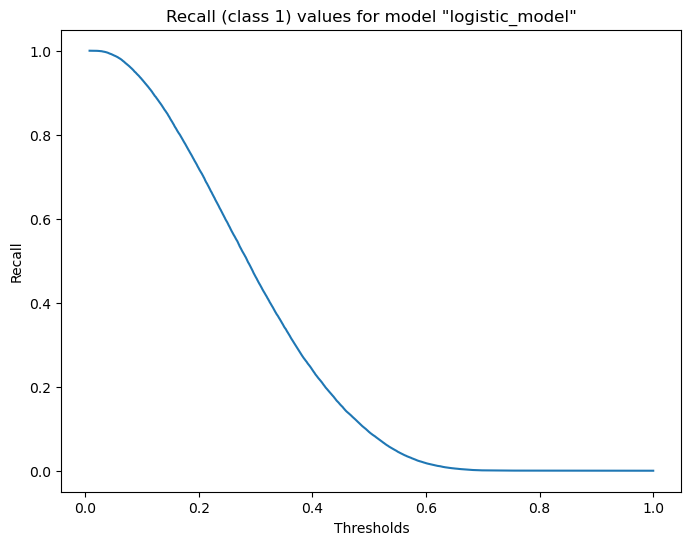

In [275]:
# Get probabilities for the positive class

probabilities = model_best_logistic_base.predict_proba(X_test_base)[:, 1]  # Only for class 1

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_base, probabilities)

# Plotting recall for various thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, recall[:-1])  # recall[:-1] because recall array has one more element than thresholds array
plt.xlabel('Thresholds')
plt.ylabel('Recall')
plt.title('Recall (class 1) values for model "logistic_model"')
plt.show()

In [279]:
# Changing the threshold to 0.3
optimal_threshold_simple_adjustment = 0.3
y_pred_threshold_simple_adjustment = (model_logistic_class_weights_1_balanced.predict_proba(X_test_base)[:, 1] >= threshold).astype(int)

In [280]:
print("Before threshold adjustment\n" + "-" *54)
print(classification_report(y_test_base, y_pred_base))
print(confusion_matrix(y_test_base, y_pred_base))

print("After threshold adjustment to 0.3\n" + "-" *54)
print(classification_report(y_test_base, y_pred_threshold_simple_adjustment))
print(confusion_matrix(y_test_base, y_pred_threshold_simple_adjustment))

Before threshold adjustment
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    153048
           1       0.34      0.68      0.46     41816

    accuracy                           0.65    194864
   macro avg       0.61      0.66      0.60    194864
weighted avg       0.77      0.65      0.68    194864

[[97993 55055]
 [13248 28568]]
After threshold adjustment to 0.3
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.28      0.44    153048
           1       0.26      0.92      0.41     41816

    accuracy                           0.42    194864
   macro avg       0.60      0.60      0.42    194864
weighted avg       0.79      0.42      0.43    194864

[[ 43467 109581]
 [  3183  38633]]


### 2. ROC Curve and Youden's J Statistic

In [281]:
fpr, tpr, thresholds = roc_curve(y_test_base, y_pred_proba_base)
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold_youden_stat = thresholds[optimal_idx]

y_pred_youden_stat = (y_pred_proba_base >= optimal_threshold_youden_stat).astype(int)


ROC-AUC Score: 0.7199265149057823
Precision-Recall AUC: 0.403356745901396
Optimal threshold by F1: 0.9999387758517451


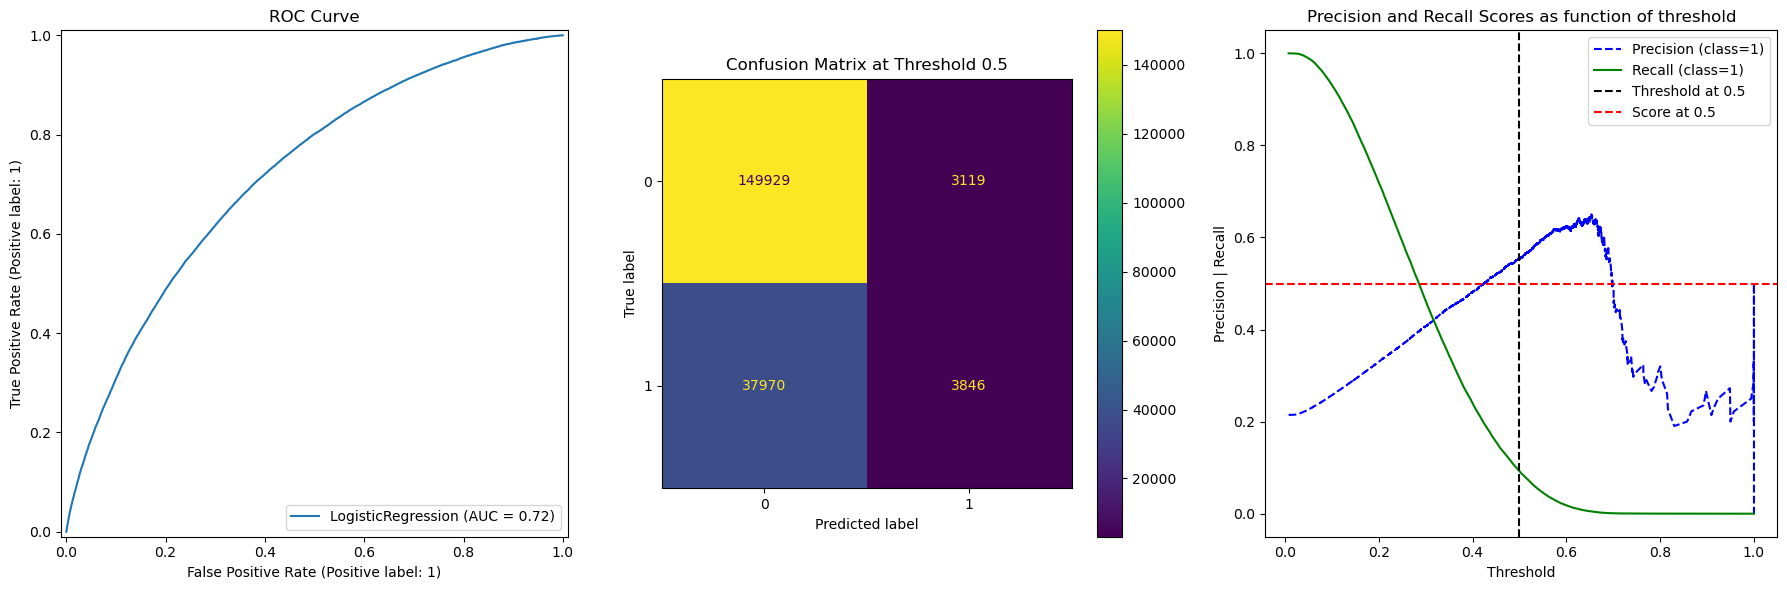

In [282]:
evaluate_model(model_best_logistic_base, X_test_base, y_test_base);

### 3. F1 Score Optimization: 
The F1 score is the harmonic mean of precision and recall,

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_base, y_pred_proba_base)

# Calculating F1 scores
f1_scores = 2 * (precision * recall) / (precision + recall)

# Finding index of the optimal F1 score
optimal_idx_f1 = np.argmax(f1_scores[:-1])
optimal_threshold_f1 = thresholds[optimal_idx_f1]

# predictions based on the optimal threshold
y_pred_f1 = (y_pred_proba_base >= optimal_threshold_f1).astype(int)

# Evaluate the performance of the F1 optimization method

accuracy_f1 = accuracy_score(y_test_base, y_pred_f1)
precision_f1 = precision_score(y_test_base, y_pred_f1)
recall_f1 = recall_score(y_test_base, y_pred_f1)
f1_f1 = f1_score(y_test_base, y_pred_f1)
roc_auc_f1 = roc_auc_score(y_test_base, y_pred_proba_base)



#### 4. Cost-Based Threshold Adjustment: 
Depending on the cost of false positives and false negatives are different. You can adjust the threshold based on these costs.

 **Cost = FP * Cost_FP + FN * Cost_FN**


In [288]:
cost_fn = 5  # Cost of false negative
cost_fp = 1  # Cost of false positive

# Calculating the cost for each threshold
cost = cost_fn * (1 - tpr) + cost_fp * fpr
optimal_idx_cost_based = np.argmin(cost)
optimal_threshold_cost_based = thresholds[optimal_idx_cost_based]

y_pred_optimal_cost_based = (y_pred_proba_base >= optimal_threshold_cost_based).astype(int)

### Bayesian Optimization


In [289]:
# Define the function needeed for the optimizer
def optimize_threshold(threshold):
    y_pred = (y_pred_proba_base >= threshold).astype(int)
    return f1_score(y_test_base, y_pred)

# Bayesian optimizer object with the function to optimize
optimizer = BayesianOptimization(
    f=optimize_threshold,
    pbounds={'threshold': (0, 1)},
    random_state=42
)

# Running the optimization
optimizer.maximize(init_points=10, n_iter=30)

# optimal threshold
optimal_threshold_bayesian_optimizer = optimizer.max['params']['threshold']
y_pred_threshold_bayesian_optimizer = (y_pred_proba_base >= optimal_threshold_bayesian_optimizer).astype(int)

|   iter    |  target   | threshold |
-------------------------------------
| 1         | 0.429     | 0.3745    |
| 2         | 0.0003823 | 0.9507    |
| 3         | 0.2795    | 0.732     |
| 4         | 0.4396    | 0.5987    |
| 5         | 0.3672    | 0.156     |
| 6         | 0.3672    | 0.156     |
| 7         | 0.3536    | 0.05808   |
| 8         | 0.01689   | 0.8662    |
| 9         | 0.4386    | 0.6011    |
| 10        | 0.3222    | 0.7081    |
| 11        | 0.4518    | 0.4746    |
| 12        | 0.4558    | 0.5247    |
| 13        | 0.4555    | 0.5042    |
| 14        | 0.4549    | 0.542     |
| 15        | 0.4558    | 0.5174    |
| 16        | 0.4559    | 0.5192    |
| 17        | 0.4561    | 0.524     |
| 18        | 0.4558    | 0.5255    |
| 19        | 0.4558    | 0.5172    |
| 20        | 0.4558    | 0.5248    |
| 21        | 0.4558    | 0.5178    |
| 22        | 0.4558    | 0.5252    |
| 23        | 0.456     | 0.5186    |
| 24        | 0.4559    | 0.5185    |
| 25        

### THRESHOLD ADJUSTMENT - EVALUATION & CONCLUSION 

                  Method  Threshold  Accuracy  Precision    Recall  F1 Score  \
0      Simple Adjustment   0.300000  0.421319   0.260657  0.923881  0.406599   
1   Youden's J Statistic   0.499221  0.648822   0.341333  0.684642  0.455549   
2  F1 Score Optimization   0.999999  0.785399   0.000000  0.000000  0.000000   
3  Cost-Based Adjustment   0.336904  0.465283   0.272589  0.894084  0.417800   
4  Bayesian Optimization   0.523048  0.671571   0.353826  0.642051  0.456230   

    AUC-ROC  
0  0.720241  
1  0.720241  
2  0.720241  
3  0.720241  
4  0.720241  


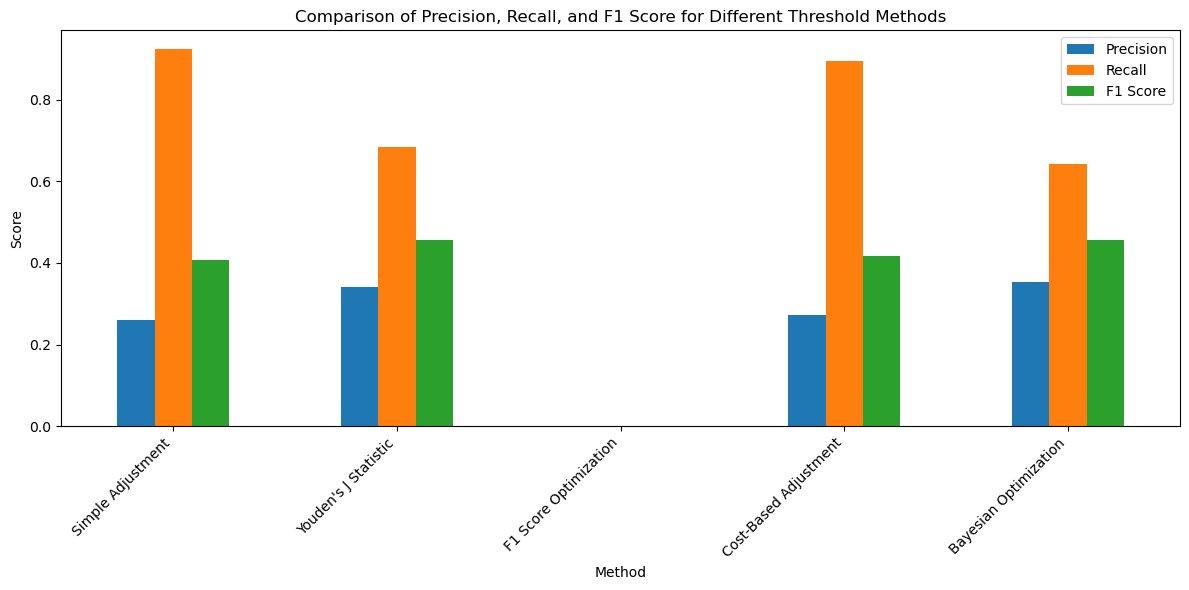

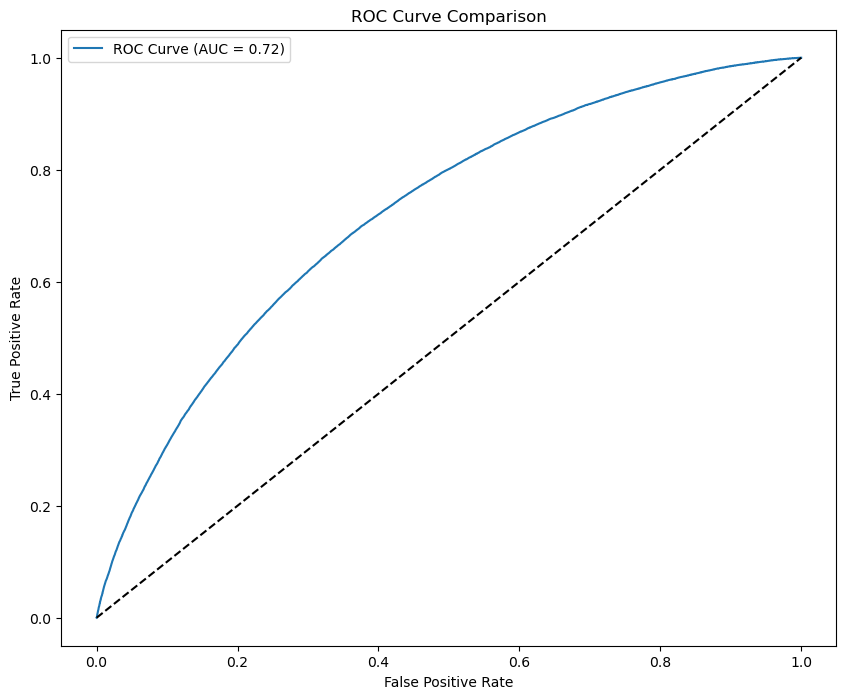

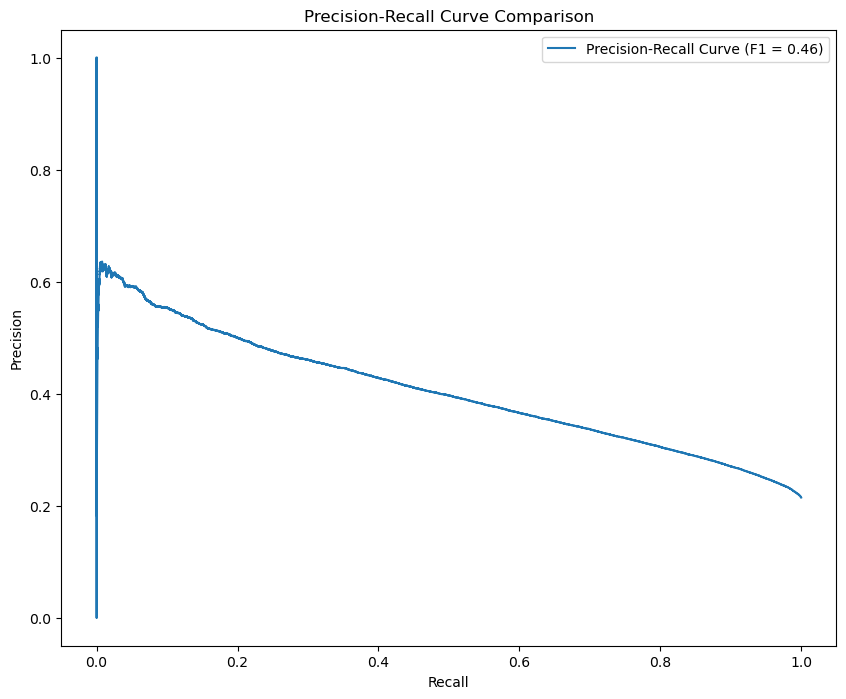

In [292]:
# probabilities using already fitted simple logistic regression model
y_pred_proba_base = model_logistic_base.predict_proba(X_test_base)[:, 1]

# Define thresholds for each method
thresholds = {
    'Simple Adjustment': optimal_threshold_simple_adjustment,
    'Youden\'s J Statistic': optimal_threshold_youden_stat,
    'F1 Score Optimization': optimal_threshold_f1,
    'Cost-Based Adjustment': optimal_threshold_cost_based,
    'Bayesian Optimization': optimal_threshold_bayesian_optimizer
}

metrics = pd.DataFrame(columns=['Method', 'Threshold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

# dictionary to store predictions
y_prediction_threshold = {}

# Iteration over the thresholds and calculating metrics
for method, threshold in thresholds.items():
    y_pred = (y_pred_proba_base >= threshold).astype(int)
    y_prediction_threshold[method] = y_pred
    
    accuracy = accuracy_score(y_test_base, y_pred)
    precision = precision_score(y_test_base, y_pred)
    recall = recall_score(y_test_base, y_pred)
    f1 = f1_score(y_test_base, y_pred)
    auc_roc = roc_auc_score(y_test_base, y_pred_proba_base)
    
    metrics = metrics.append({
        'Method': method,
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }, ignore_index=True)

print(metrics)

# Visualize the metrics
metrics.set_index('Method', inplace=True)

# Plot Precision, Recall, and F1 Score for each method
metrics[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Precision, Recall, and F1 Score for Different Threshold Methods')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot ROC Curve for each method
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test_base, y_pred_proba_base)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test_base, y_pred_proba_base):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Plot Precision-Recall Curve for each method
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_test_base, y_pred_proba_base)
plt.plot(recall, precision, label=f'Precision-Recall Curve (F1 = {f1_score(y_test_base, (y_pred_proba_base >= 0.5).astype(int)):.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()


__To note: The threshold optimization methods are used to adjust the threshold of the model to classify the positive class. The threshold is adjusted to maximize the F1 score, minimize the cost, or optimize the Youden's J statistic. The threshold adjustment can be used to balance the trade-off between precision and recall, depending on the problem requirements.__
For the 3rd method, `F1 optimazation` the threshold is adjusted to maximize the F1 score. The F1 score is the harmonic mean of precision and recall, and it is used to balance the trade-off between precision and recall. The F1 score is maximized when both precision and recall are high. The threshold is adjusted to maximize the F1 score, however it has gotten out excessive since the threshold is at 0.99 which basically implicate that quasi-all loans applications would be rejected - __due to the severe class imbalance__

In [396]:
print(classification_report(y_test_base, y_prediction_threshold['F1 Score Optimization']))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88    153048
           1       0.00      0.00      0.00     41816

    accuracy                           0.79    194864
   macro avg       0.39      0.50      0.44    194864
weighted avg       0.62      0.79      0.69    194864



## Resampling Techniques

In [ ]:
# Resample the dataset
smote = SMOTE(random_state=42)
X_resampled_base, y_resampled_base = smote.fit_resample(X_train_base, y_train_base)

In [390]:

# Train the model on the resampled data
model_logistic_resampled_base = LogisticRegression(C=0.1 ,class_weight='balanced',max_iter=1000)
model_logistic_resampled_base.fit(X_resampled_base, y_resampled_base)

# Evaluate the model
y_pred_resampled_base = model_logistic_resampled_base.predict(X_test_base)

In [393]:

print("Before threshold adjustment (Class weights adjustments) \n" + "-" *54)
print(classification_report(y_test_base, y_pred_logistic_class_weights_1_balanced))
print(confusion_matrix(y_test_base, y_pred_logistic_class_weights_1_balanced))

print(" Baseline model - balanced class weights after Resampling \n" + "-" *54)
print(classification_report(y_test_base, y_pred_resampled_base))
print(confusion_matrix(y_test_base, y_pred_resampled_base))

Before threshold adjustment (Class weights adjustments) 
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    153048
           1       0.34      0.68      0.46     41816

    accuracy                           0.65    194864
   macro avg       0.61      0.66      0.60    194864
weighted avg       0.77      0.65      0.68    194864

[[97993 55055]
 [13248 28568]]
 Baseline model - balanced class weights after Resampling 
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.64      0.74    153048
           1       0.34      0.67      0.45     41816

    accuracy                           0.65    194864
   macro avg       0.61      0.66      0.60    194864
weighted avg       0.76      0.65      0.68    194864

[[98669 54379]
 [13702 28114]]


ROC-AUC Score: 0.716539439506266
Precision-Recall AUC: 0.39885273173905716
Optimal threshold by F1: 0.9999997477024604


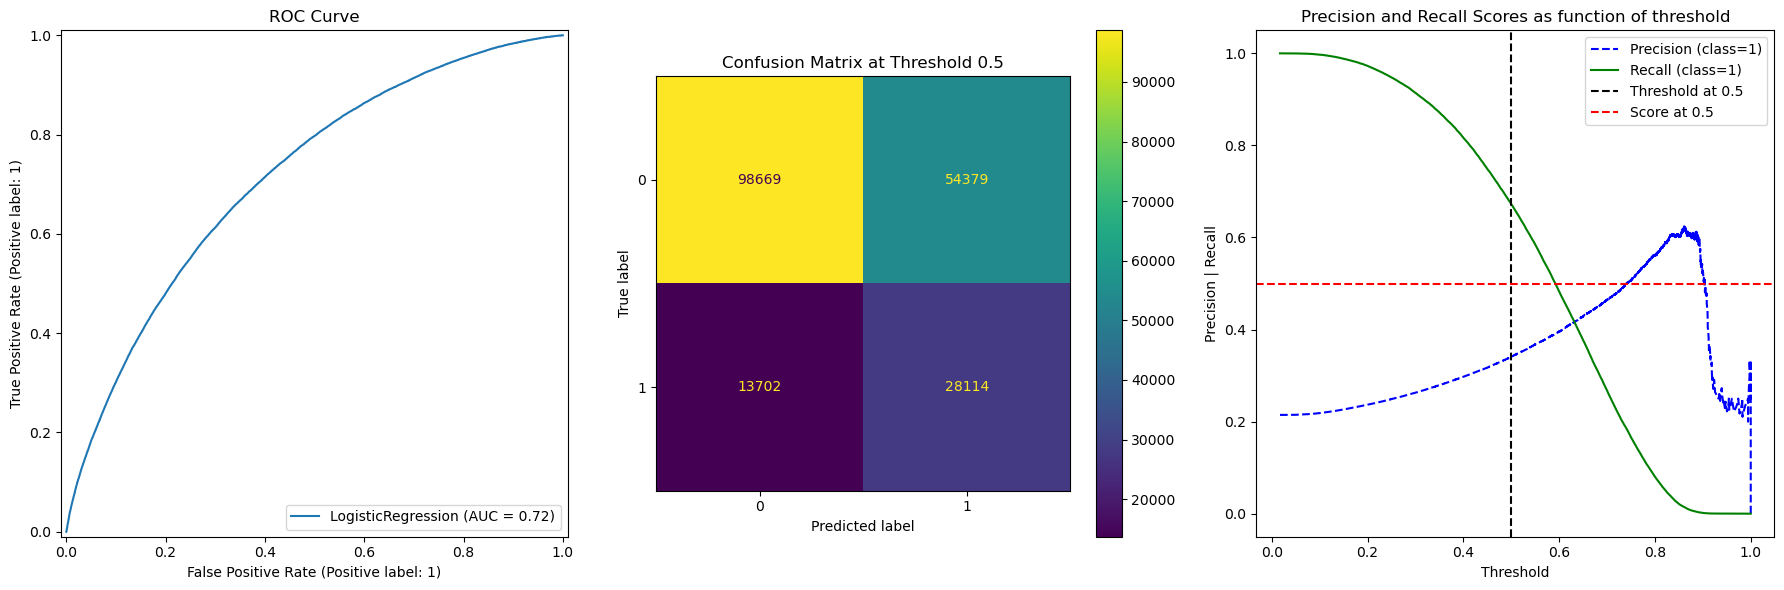

In [392]:
evaluate_model(model_logistic_resampled_base, X_test_base, y_test_base);

# RANDOM FOREST MODEL

In [10]:
def evaluate_model_forest(model, X_test, y_test):
    """
    Evaluate the RandomForest model and display evaluation metrics and plots.
    
    Parameters:
        model: The trained machine learning model.
        X_test (DataFrame): Test features.
        y_test (Series): True labels for test data.
    """
    # ROC-AUC score
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print("ROC-AUC Score:", roc_auc)

    # Precision-Recall curve components
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    print("Precision-Recall AUC:", pr_auc)

    # Calculate F1 scores from precision and recall
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0
    print("Optimal threshold by F1:", optimal_threshold)

    # Setup for 3x1 subplot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[0, 0])
    ax[0, 0].set_title('ROC Curve')

    # Precision-Recall Curve
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='RandomForest')
    pr_display.plot(ax=ax[0, 1])
    ax[0, 1].set_title('Precision-Recall Curve')
    ax[0, 1].axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    ax[0, 1].legend()

    # Confusion Matrix at Normal Threshold (0.5)
    y_pred_normal = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_normal)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1, 0])
    ax[1, 0].set_title('Confusion Matrix at Threshold 0.5')

    # Precision and Recall vs. Threshold
    ax[1, 1].plot(thresholds, precision[:-1], 'b--', label='Precision (class=1)')
    ax[1, 1].plot(thresholds, recall[:-1], 'g-', label='Recall (class=1)')
    ax[1, 1].set_ylabel('Precision | Recall')
    ax[1, 1].set_xlabel('Threshold')
    ax[1, 1].set_title('Precision and Recall Scores as function of threshold')
    ax[1, 1].axvline(x=0.5, color='k', linestyle='--', label='Threshold at 0.5')
    ax[1, 1].axhline(y=0.5, color='r', linestyle='--', label='Score at 0.5')
    ax[1, 1].legend(loc='best')

    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred_normal))

    return precision, recall, thresholds

In [11]:
def evaluate_model(model, X_test, y_test, model_name='Model'):
    """
    Evaluate the model and display evaluation metrics and plots.
    
    Parameters:
        model: The trained machine learning model.
        X_test (DataFrame): Test features.
        y_test (Series): True labels for test data.
        model_name (str): Name of the model for display purposes.
    """
    # ROC-AUC score
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print("ROC-AUC Score:", roc_auc)

    # Precision-Recall curve components
    precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall, precision)
    print("Precision-Recall AUC:", pr_auc)

    # Calculate F1 scores from precision and recall
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.nanargmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0
    print("Optimal threshold by F1:", optimal_threshold)

    # Setup for 2x2 subplot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[0, 0])
    ax[0, 0].set_title('ROC Curve')

    # Precision-Recall Curve
    pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name=model_name)
    pr_display.plot(ax=ax[0, 1])
    ax[0, 1].set_title('Precision-Recall Curve')
    ax[0, 1].axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    ax[0, 1].legend()

    # Confusion Matrix at Normal Threshold (0.5)
    y_pred_normal = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_normal)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1, 0])
    ax[1, 0].set_title('Confusion Matrix at Threshold 0.5')

    # Precision and Recall vs. Threshold
    ax[1, 1].plot(thresholds, precision[:-1], 'b--', label='Precision (class=1)')
    ax[1, 1].plot(thresholds, recall[:-1], 'g-', label='Recall (class=1)')
    ax[1, 1].set_ylabel('Precision | Recall')
    ax[1, 1].set_xlabel('Threshold')
    ax[1, 1].set_title('Precision and Recall Scores as function of threshold')
    ax[1, 1].axvline(x=0.5, color='k', linestyle='--', label='Threshold at 0.5')
    ax[1, 1].axhline(y=0.5, color='r', linestyle='--', label='Score at 0.5')
    ax[1, 1].legend(loc='best')

    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred_normal))

    return precision, recall, thresholds


In [12]:
X, y, preprocessor = preprocess_data(df, include_macro=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
preprocessor

In [14]:
model_rfc_base = RandomForestClassifier(random_state=42, n_jobs=4)
model_rfc_base.fit(X_train, y_train)

accuracy_base = model_rfc_base.score(X_test, y_test)
print(f"Base Model Accuracy: {accuracy_base:.2f}")

Base Model Accuracy: 0.79


ROC-AUC Score: 0.7171335372195451
Precision-Recall AUC: 0.40409815417192635
Optimal threshold by F1: 0.25


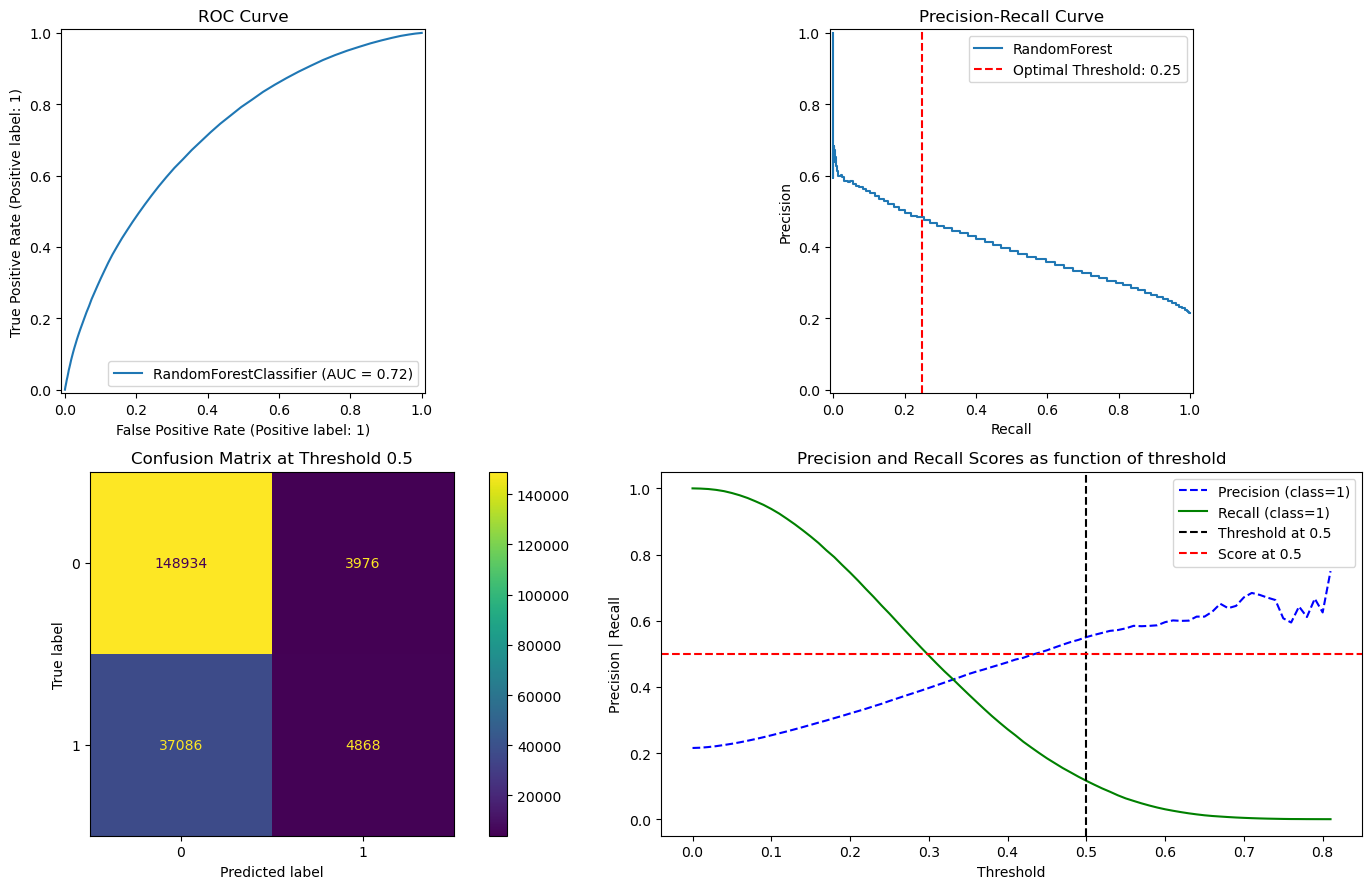


Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.97      0.88    152910
           1       0.55      0.12      0.19     41954

    accuracy                           0.79    194864
   macro avg       0.68      0.55      0.54    194864
weighted avg       0.75      0.79      0.73    194864



In [15]:
precision_model_rfc_base, recall_model_model_rfc_base, thresholds_model_rfc_base = evaluate_model_forest(model_rfc_base, X_test, y_test)

## HYPERPARAMETER TUNING

In [301]:
#Trainning a subset of the data for develpment stage, due to computational constraints
subset_fraction = 0.2
df_subset, further_test = train_test_split(df, test_size=(1 - subset_fraction), stratify=df['loan_status_target_variable'], random_state=42)

In [321]:
#df = df_subset
df_subset.shape

(194863, 36)

In [303]:
X, y, preprocessor, feature_names = preprocess_data(df_subset, include_macro=False)
print(X.shape)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor

(194863, 134)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<function preprocess_data.<locals>.selective_log at 0x46d37d760>)),
                                                 ('scaler', RobustScaler())]),
                                 ['annual_inc', 'avg_cur_bal', 'dti',
                                  'int_rate', 'loan_amnt',
                                  'loan_date_days_from_reference', 'mort_acc',
                                  'num_accts_ever_120_pd', 'num_sats',
                                  'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
                                  'pub_rec', 'pub_rec_bankruptcies',
                                  'revol_bal', 'revol_util', 'total_acc']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['addr_state', 'purpose', 'term_clean',
                                  'sub_grade', 'verification_status', 'grade',
                                  'home_ownership', 'initial_list_status',
                                  'application_type'])])

In [22]:
# parameter grid for RandomForest
param_dist = {
    'n_estimators': [100, 200, 400, 800, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# RandomForestClassifier
model_rfc_base_hyper = RandomForestClassifier(random_state=42)

# StratifiedKFold
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search_rfc_base_hyper = RandomizedSearchCV(
    estimator=model_rfc_base_hyper,
    param_distributions=param_dist,
    n_iter=5,  
    cv=strat_k_fold,
    scoring='roc_auc',  # Since we are dealing with imbalanced data
    verbose=2,
    random_state=42,
    n_jobs=-1  
)

random_search_rfc_base_hyper.fit(X, y)

best_rf_base = random_search_rfc_base_hyper.best_estimator_

# best score
print("Best parameters found: ", random_search_rfc_base_hyper.best_params_)
print("Best AUC score: ", random_search_rfc_base_hyper.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END class_weight=balanced_subsample, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END class_weight=balanced_subsample, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END class_weight=balanced_subsample, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END class_weight=balanced_subsample, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END class_weight=balanced_subsample, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END class_weight=balanced_subsample, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.7s
[CV] END class_we

/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END class_weight=balanced_subsample, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  49.0s
[CV] END class_weight=balanced_subsample, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END class_weight=balanced_subsample, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END class_weight=balanced_subsample, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END class_weight=balanced_subsample, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END class_weight=balanced_subsample, max_depth=6, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END class_weight=balanced_subsample, max_depth=6, max_features=sqrt, min_samples_le

/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in 

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 6, 'class_weight': 'balanced_subsample'}
Best AUC score:  0.7258434297661454


In [309]:
best_rf_params = {
    'n_estimators': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 6,
    'class_weight': 'balanced_subsample'
}

# Initialize the Random Forest model with the best parameters
model_hyper_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)

In [312]:
model_hyper_rf_model.fit(X_train_base, y_train_base) # Model fitting

RandomForestClassifier(class_weight='balanced_subsample', max_depth=6,
                       min_samples_split=5, random_state=42)

In [314]:
y_pred_rf_hyper = model_hyper_rf_model.predict(X_test_base) # Predictions
y_pred_proba_rf_hyper = model_hyper_rf_model.predict_proba(X_test_base)[:, 1]

In [320]:
print(classification_report(y_test_base, y_pred_rf_hyper))

              precision    recall  f1-score   support

           0       0.88      0.60      0.72     30610
           1       0.32      0.69      0.44      8363

    accuracy                           0.62     38973
   macro avg       0.60      0.65      0.58     38973
weighted avg       0.76      0.62      0.66     38973



ROC-AUC Score: 0.7050888402787546
Precision-Recall AUC: 0.38513244215355
Optimal threshold by F1: 0.5269637596888647


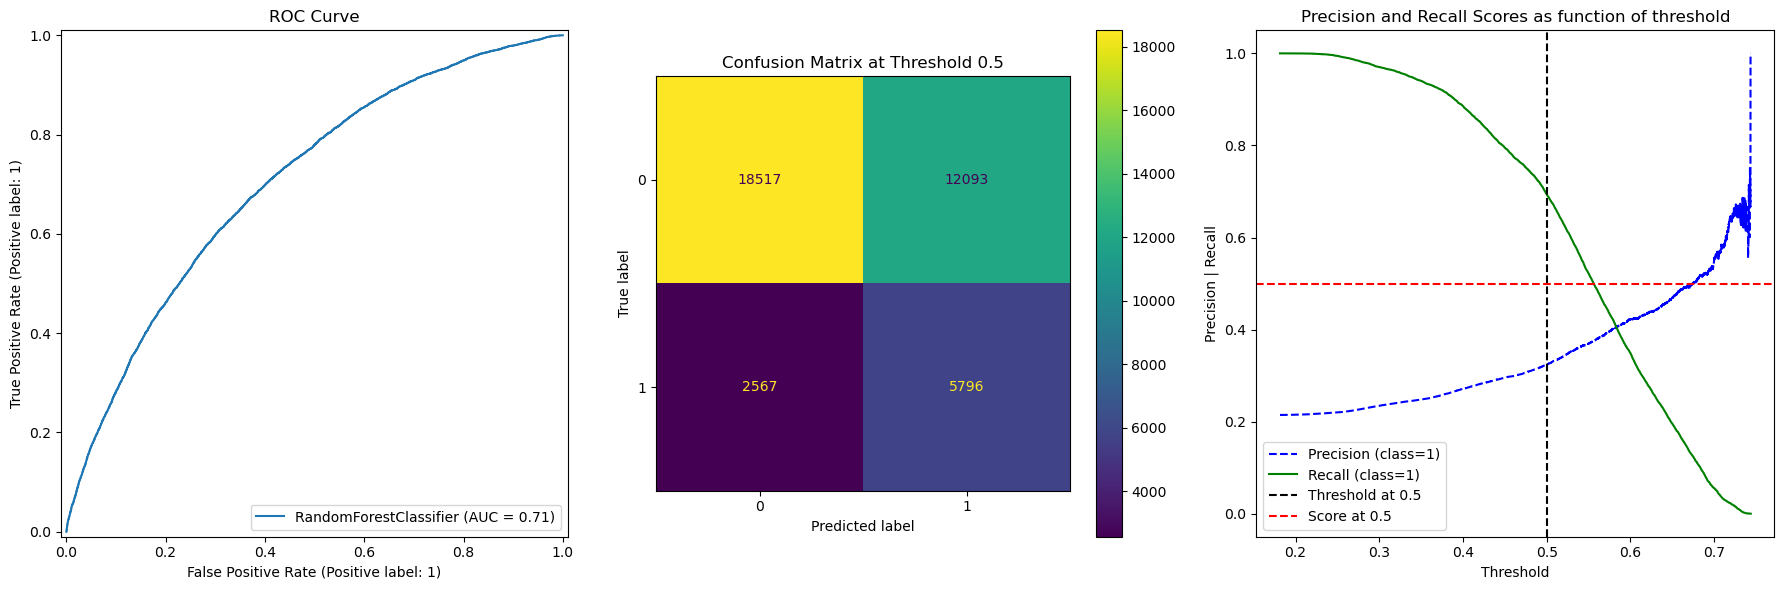

In [318]:
evaluate_model(model_hyper_rf_model, X_test_base, y_test_base);

# XGBOOST

In [330]:
X, y, preprocessor, feature_names_xg = preprocess_data(df, include_macro=False)
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
preprocessor

(974317, 135)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<function preprocess_data.<locals>.selective_log at 0x3c0b80d60>)),
                                                 ('scaler', RobustScaler())]),
                                 ['annual_inc', 'avg_cur_bal', 'dti',
                                  'int_rate', 'loan_amnt',
                                  'loan_date_days_from_reference', 'mort_acc',
                                  'num_accts_ever_120_pd', 'num_sats',
                                  'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
                                  'pub_rec', 'pub_rec_bankruptcies',
                                  'revol_bal', 'revol_util', 'total_acc']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['addr_state', 'purpose', 'term_clean',
                                  'sub_grade', 'verification_status', 'grade',
                                  'home_ownership', 'initial_list_status',
                                  'application_type'])])

In [332]:

# Calculate scale_pos_weight
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'scale_pos_weight': scale_pos_weight
}

model_xgb = xgb.XGBClassifier(**params)

# Train
model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True, early_stopping_rounds=20)

y_pred_proba_xgboost_base = model_xgb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_xgboost_base)
print(f"ROC AUC Score: {roc_auc}")


[0]	validation_0-auc:0.70768
[1]	validation_0-auc:0.71071
[2]	validation_0-auc:0.71186
[3]	validation_0-auc:0.71231
[4]	validation_0-auc:0.71295
[5]	validation_0-auc:0.71345
[6]	validation_0-auc:0.71447
[7]	validation_0-auc:0.71486
[8]	validation_0-auc:0.71542
[9]	validation_0-auc:0.71592
[10]	validation_0-auc:0.71664
[11]	validation_0-auc:0.71707
[12]	validation_0-auc:0.71761
[13]	validation_0-auc:0.71827
[14]	validation_0-auc:0.71897
[15]	validation_0-auc:0.71934
[16]	validation_0-auc:0.71973
[17]	validation_0-auc:0.72009
[18]	validation_0-auc:0.72042
[19]	validation_0-auc:0.72094
[20]	validation_0-auc:0.72119
[21]	validation_0-auc:0.72152
[22]	validation_0-auc:0.72189
[23]	validation_0-auc:0.72232
[24]	validation_0-auc:0.72258
[25]	validation_0-auc:0.72293
[26]	validation_0-auc:0.72355
[27]	validation_0-auc:0.72382
[28]	validation_0-auc:0.72416
[29]	validation_0-auc:0.72464
[30]	validation_0-auc:0.72491
[31]	validation_0-auc:0.72515
[32]	validation_0-auc:0.72542
[33]	validation_0-au

In [338]:
y_pred_proba_xgboost_base = model_xgb.predict_proba(X_test)[:, 1]
y_pred_xgboost_base = (y_pred_proba_xgboost_base >= 0.4).astype(int)
classification_report_xgboost_base = classification_report(y_test, y_pred_xgboost_base)
print(classification_report_xgboost_base)

              precision    recall  f1-score   support

           0       0.91      0.48      0.63    153048
           1       0.30      0.83      0.44     41816

    accuracy                           0.56    194864
   macro avg       0.61      0.66      0.54    194864
weighted avg       0.78      0.56      0.59    194864



ROC-AUC Score: 0.7330610169051875
Precision-Recall AUC: 0.4265213592639849
Optimal threshold by F1: 0.5278868


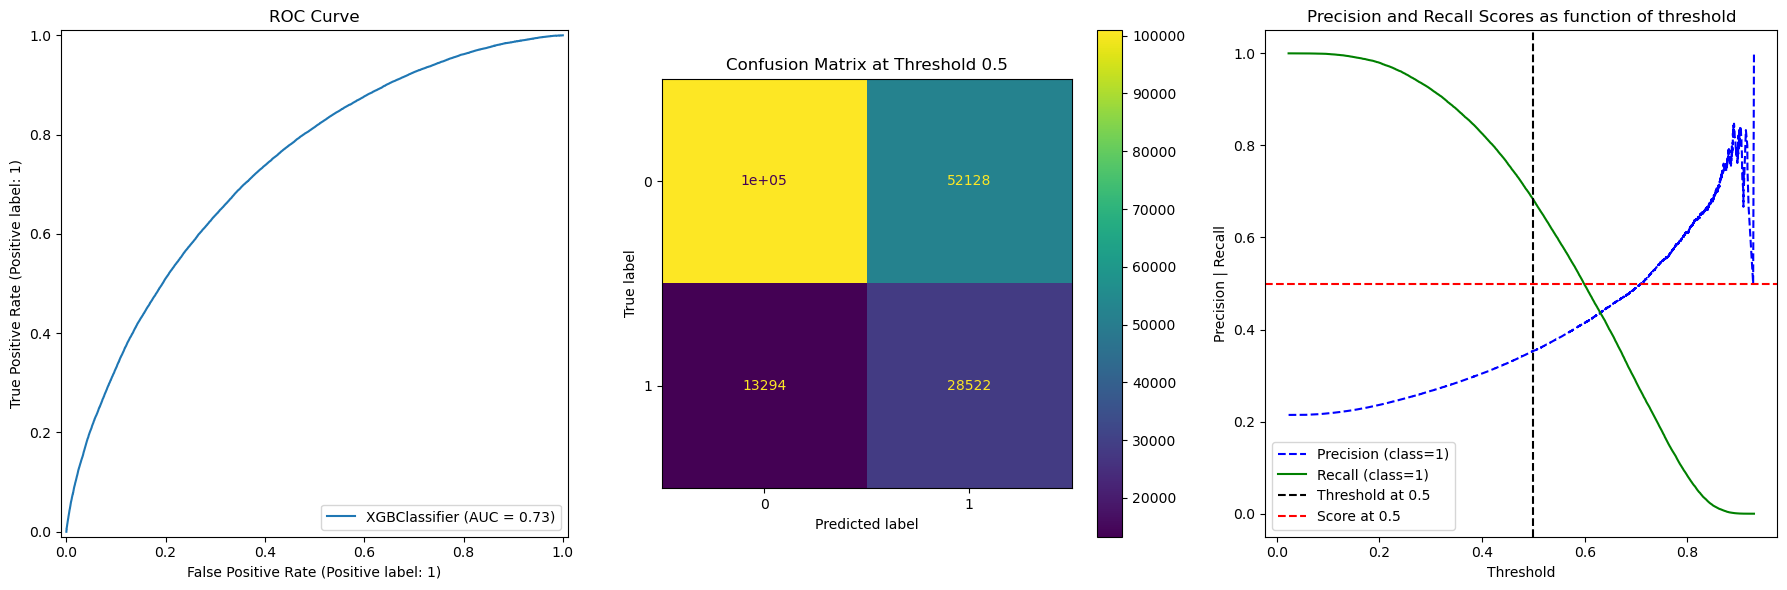

In [333]:
precision_model_xgboost_base, recall_model_xgboost_base, thresholds_xgboost_base = evaluate_model(model_xgb, X_test, y_test)

In [344]:
print(classification_report(y_test, y_pred_xgboost_base))

              precision    recall  f1-score   support

           0       0.91      0.48      0.63    153048
           1       0.30      0.83      0.44     41816

    accuracy                           0.56    194864
   macro avg       0.61      0.66      0.54    194864
weighted avg       0.78      0.56      0.59    194864



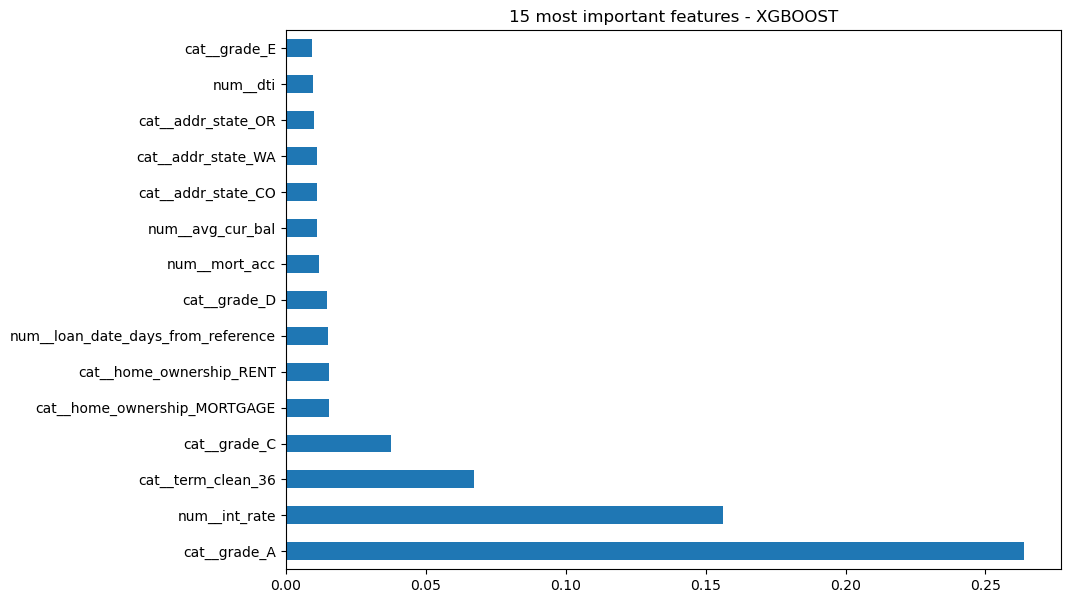

In [28]:
feature_names = preprocessor.get_feature_names_out()
features_importances_base = pd.Series(model_xgb.feature_importances_, index=feature_names)
features_importances_base.nlargest(15).plot(kind='barh', figsize=(10,7))
plt.title("15 most important features - XGBOOST")
plt.show()


#### Hyperparameter tuning

In [38]:
%%time
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {'learning_rate': [0.01, 0.05, 0.1,0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [scale_pos_weight, 2, 3],
         'max_depth': [3,4, 7,9,10, 12],
         'gamma': [0, 0.01, 0.1],
         'min_child_weight': [1,3,9,10]
         }

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV to tune the hyperparameter
random_base_1 = RandomizedSearchCV(model_xgb, 
                            param_distributions=params, 
                            cv=kfold,
                            n_iter=10, 
                            scoring='recall',
                            n_jobs=-1)

random_base_1.fit(X_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

/Users/brandontchakaniyungeko/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best hyperparameter: {'scale_pos_weight': 3.659832246039142, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1}
Best score: 0.7519490177159288
CPU times: user 2min 21s, sys: 29 s, total: 2min 50s
Wall time: 1min 50s


ROC-AUC Score: 0.7817012817750066
Precision-Recall AUC: 0.47647909998251037
Optimal threshold by F1: 0.54825073


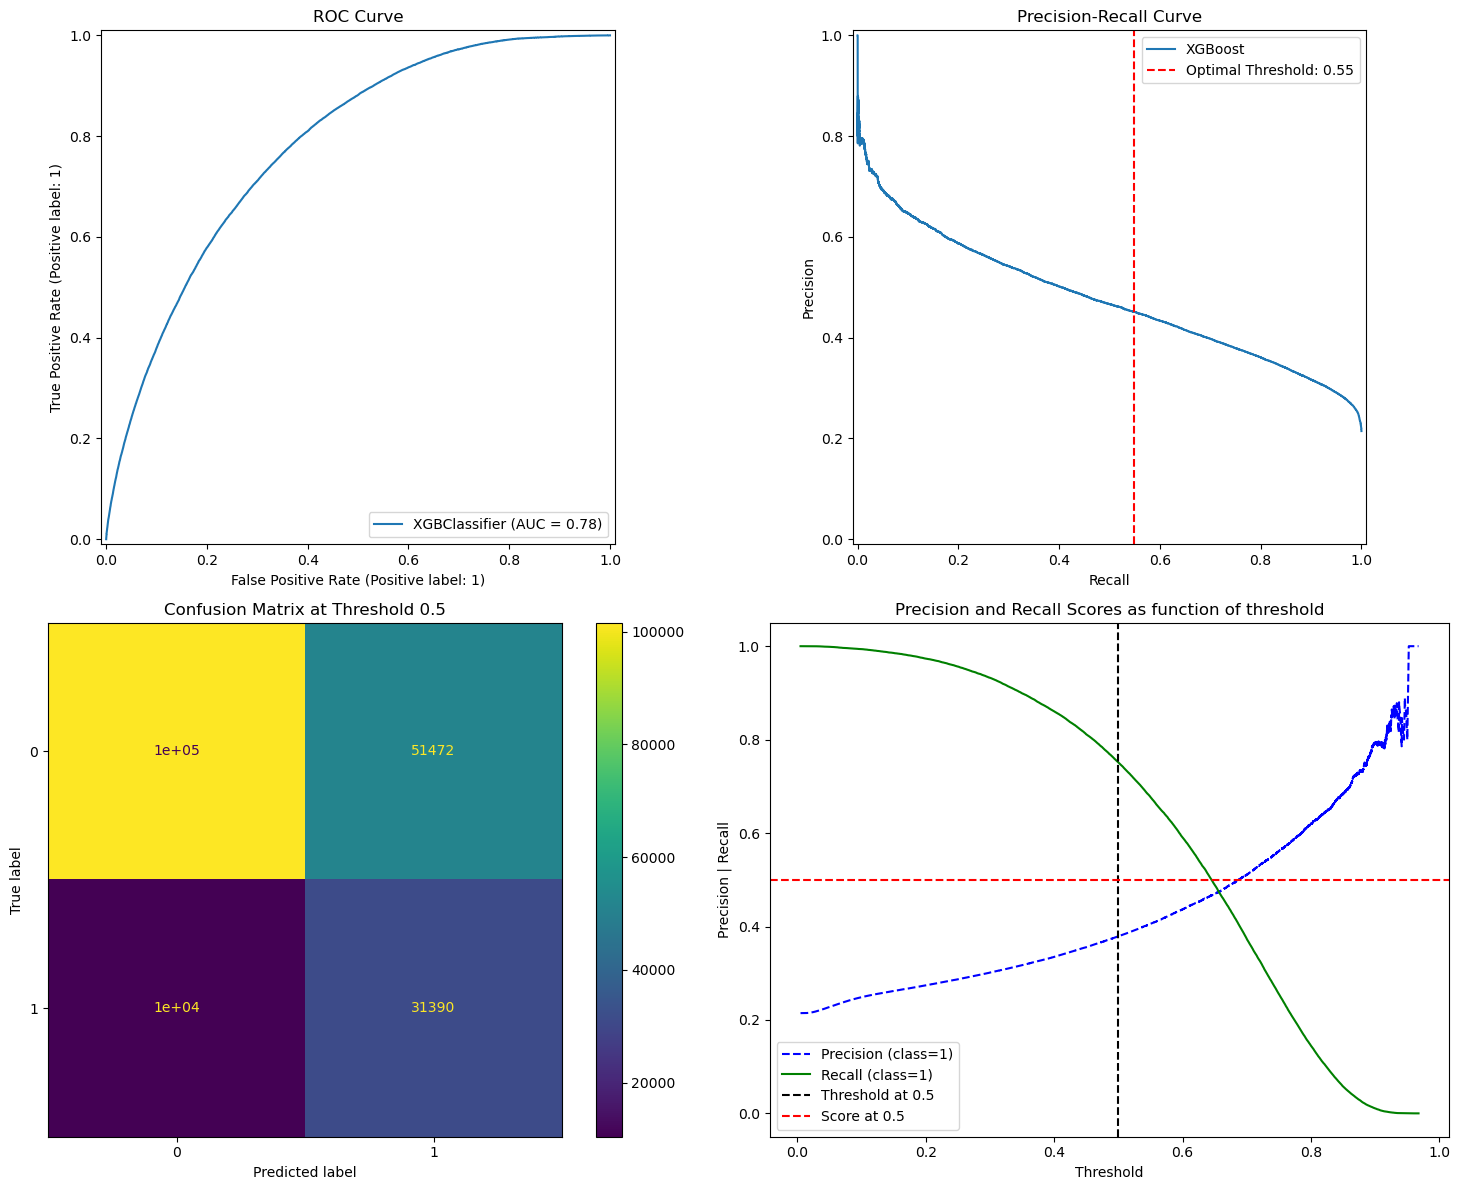


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.66      0.77    153048
           1       0.38      0.75      0.50     41816

    accuracy                           0.68    194864
   macro avg       0.64      0.71      0.64    194864
weighted avg       0.79      0.68      0.71    194864



In [48]:
best_model_base = random_base_1.best_estimator_
evaluate_model(best_model_base, X_test, y_test, model_name='XGBoost');

In [39]:
%%time
scale_pos_weight = (0.7854 * 974317) / (0.2146 * 974317)

params = {'learning_rate': [0.01, 0.05, 0.1,0.2],
         'n_estimators': [100, 200, 400],
         'scale_pos_weight': [scale_pos_weight, 2],
         'max_depth': [3,4, 7,9,10, 12, 15, 20],
         'gamma': [0, 0.01, 0.1],
         'min_child_weight': [1,3,9,10]
         }

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV to tune the hyperparameter
random_base_1 = RandomizedSearchCV(model_xgb, 
                            param_distributions=params, 
                            cv=kfold,
                            n_iter=10, 
                            scoring='roc_auc',
                            n_jobs=-1)

random_base_1.fit(X_train, y_train)

print('Best hyperparameter:', random.best_params_)
print('Best score:', random.best_score_)

Best hyperparameter: {'scale_pos_weight': 3.659832246039142, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.1}
Best score: 0.7519490177159288
CPU times: user 34.2 s, sys: 15.6 s, total: 49.8 s
Wall time: 2min 13s


In [341]:
# Best parameters found during hyperparameter tuning
best_params_xgboost = {
    'scale_pos_weight': 3.659832246039142,
    'n_estimators': 400,
    'min_child_weight': 3,
    'max_depth': 7,
    'learning_rate': 0.01,
    'gamma': 0.1,
    'objective': 'binary:logistic',
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Initialize the XGBoost model with the best parameters
model_hyper_xgb_base = xgb.XGBClassifier(**best_params_xgboost, random_state=42)

In [347]:
model_hyper_xgb_base.fit(X_train, y_train) # Model fitting

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [350]:
y_pred_xgboost_hyper = model_hyper_xgb_base.predict(X_test)
y_pred_proba_xgboost_hyper = model_hyper_xgb_base.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       0.88      0.65      0.75    153048
           1       0.35      0.68      0.46     41816

    accuracy                           0.66    194864
   macro avg       0.62      0.67      0.61    194864
weighted avg       0.77      0.66      0.69    194864



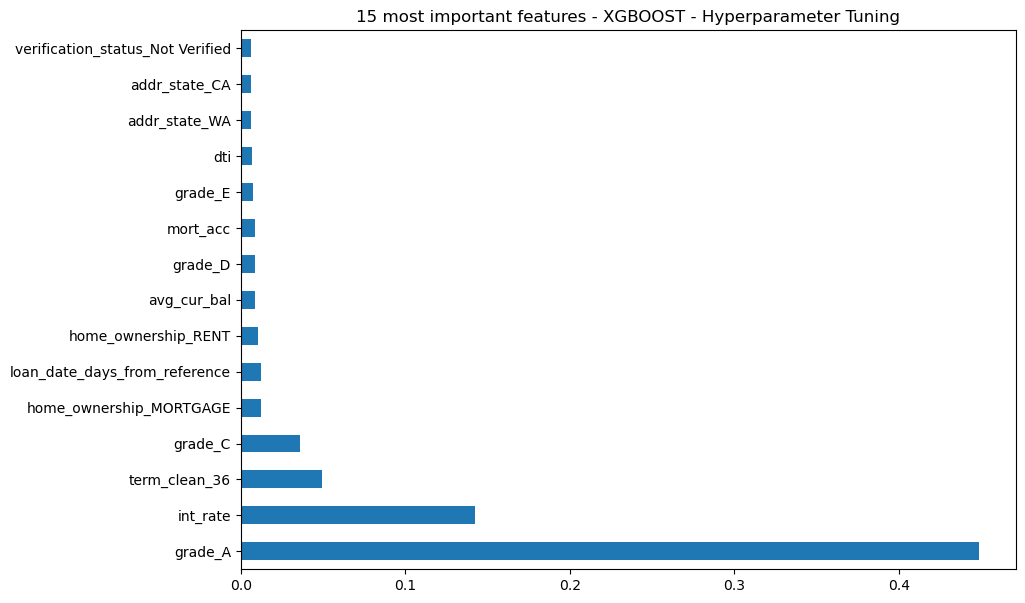

In [361]:
features_importances_base = pd.Series(model_hyper_xgb_base.feature_importances_, index=feature_names_xg)
features_importances_base.nlargest(15).plot(kind='barh', figsize=(10,7))
plt.title("15 most important features - XGBOOST - Hyperparameter Tuning")
plt.show()